In [30]:
# Fonction renvoyant le spectrogramme associé au graphe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from obspy import read
from scipy import signal
from matplotlib import cm
import cv2
from scipy.fft import fft

def spectrogramme(i):
    cat_directory = '../data/lunar/training/catalogs/'
    cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
    cat = pd.read_csv(cat_file)
    row = cat.iloc[i]
    
    # Extraire les temps d'arrivée
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    arrival_time_rel = row['time_rel(sec)']
    test_filename = row.filename
    data_directory = '../data/lunar/training/data/S12_GradeA/'
    csv_file = f'{data_directory}{test_filename}.csv'
    
    # Lire les données CSV
    data_cat = pd.read_csv(csv_file)
    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())
    
    # Tracer les données
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)
    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')
    ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
    ax.legend()
    
    # Convertir temps absolus en datetime
    csv_times_dt = [datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S.%f') for ts in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values]
    
    # Tracer les données en temps absolu
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times_dt, csv_data)
    ax.set_xlim((np.min(csv_times_dt), np.max(csv_times_dt)))
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (month-day hour)')
    ax.set_title(f'{test_filename}', fontweight='bold')
    ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
    ax.legend()

    # Lire le fichier mseed
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)

    # Extraire les données du premier trace
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    
    # Calculer le temps d'arrivée relatif
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    
    # Tracer les données du trace
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times, tr_data)
    ax.axvline(x=arrival, color='red', label='Rel. Arrival')
    ax.legend(loc='upper left')
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Créer un vecteur pour le temps absolu
    tr_times_dt = [starttime + timedelta(seconds=tr_val) for tr_val in tr_times]

    # Tracer le résultat absolu
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times_dt, tr_data)
    ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
    ax.legend()
    ax.set_xlim([min(tr_times_dt), max(tr_times_dt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Calculer la FFT du signal
    n = len(tr.data)
    sampling_rate = tr.stats.sampling_rate
    T = 1.0 / sampling_rate
    yf = fft(tr.data)
    xf = np.fft.fftfreq(n, T)[:n // 2]
    spectrum = 2.0 / n * np.abs(yf[0:n // 2])
    
    # Trouver la fréquence et l'amplitude maximales
    max_index = np.argmax(spectrum)
    max_frequency = xf[max_index]
    max_amplitude = spectrum[max_index]

    # Calculer la largeur à mi-hauteur (FWHM)
    half_max = max_amplitude / 2
    indices_above_half_max = np.where(spectrum >= half_max)[0]
    
    if len(indices_above_half_max) > 0:
        fwhm = xf[indices_above_half_max[-1]] - xf[indices_above_half_max[0]]
    else:
        fwhm = 0

    # Calculer le pourcentage basé sur la largeur à mi-hauteur
    percentage = (fwhm / max_frequency) * 100 if max_frequency != 0 else 5
    if percentage == 0.0: 
        percentage = 5    
    print("Largeur à mi-hauteur (FWHM) :", fwhm)
    print("Pourcentage basé sur la largeur à mi-hauteur :", percentage)
    print("Fréquence maximale :", max_frequency, "Hz")
    print("Amplitude maximale :", max_amplitude)

    # Afficher le spectre de puissance
    plt.plot(xf, spectrum)
    plt.title("Spectre de Puissance avec Pics")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.axvline(x=max_frequency, color='red', linestyle='--', label='Fréquence max')
    plt.legend()

    # Définir la bande passante du filtre
    span = (percentage / 100) * max_frequency

    minfreq = max_frequency - span
    maxfreq = max_frequency + span

    if minfreq <= 0:
        minfreq = 0.0001
    else :
        minfreq = max_frequency - span
    if maxfreq <= 0:
        maxfreq = 0.0001
    else:
        maxfreq = max_frequency + span


    
    print(minfreq, maxfreq)

    # Créer un trace séparé pour les données filtrées
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    # Calculer le spectrogramme
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

    # Initialiser la figure pour le spectrogramme
    fig = plt.figure(figsize=(10, 6))
    file_name = f'{data_directory}{test_filename}.png'
    
    # Tracer le spectrogramme (sans axes)
    ax = plt.subplot(1, 1, 1)
    vals = ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
    ax.set_axis_off()

    # Sauvegarder le spectrogramme sans axes ni étiquettes
    plt.savefig(f'spectrogram_{i}.png', dpi=300, bbox_inches='tight', pad_inches=0)

    # Optionnel : Afficher le tracé
    plt.show()

    return {
        "max_frequency": max_frequency,
        "max_amplitude": max_amplitude,
        "fwhm": fwhm,
        "percentage": percentage,
        "min_frequency": minfreq,
        "max_frequency": maxfreq,
        "test_filename": test_filename
    }


Largeur à mi-hauteur (FWHM) : 0.5969908422444712
Pourcentage basé sur la largeur à mi-hauteur : 72.08983801763776
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 2.1455868682868452e-11
0.23112981756115802 1.4251115020501004


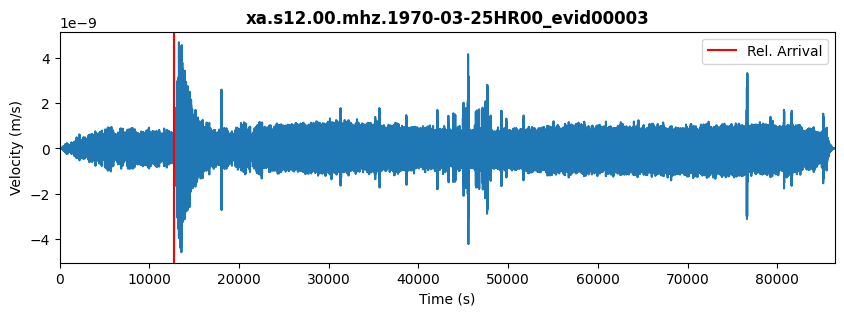

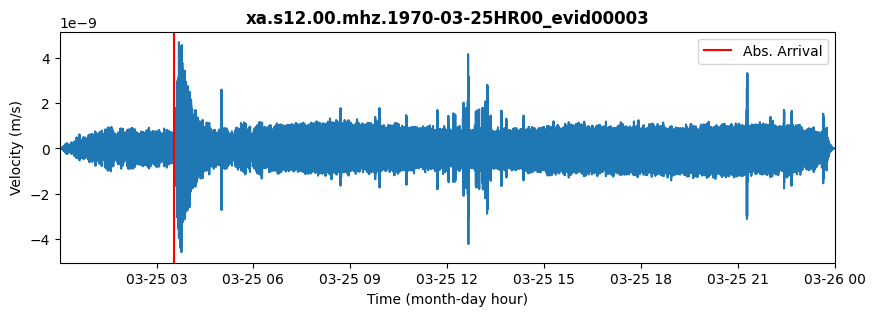

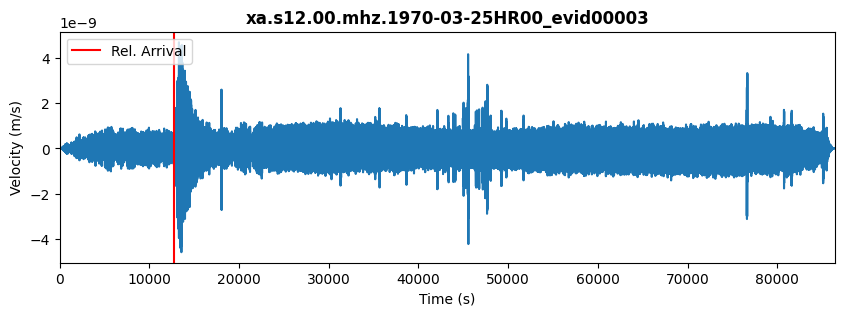

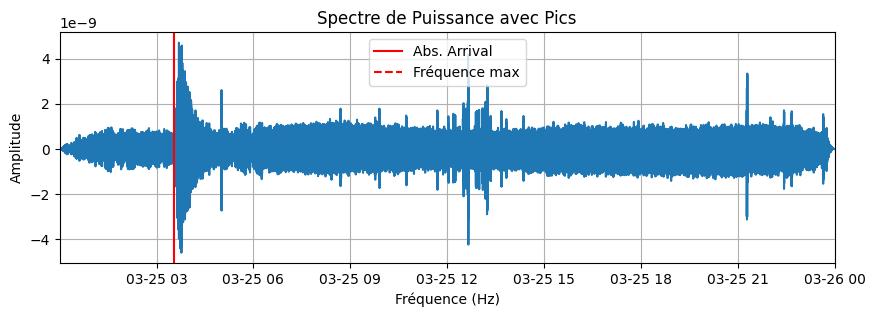

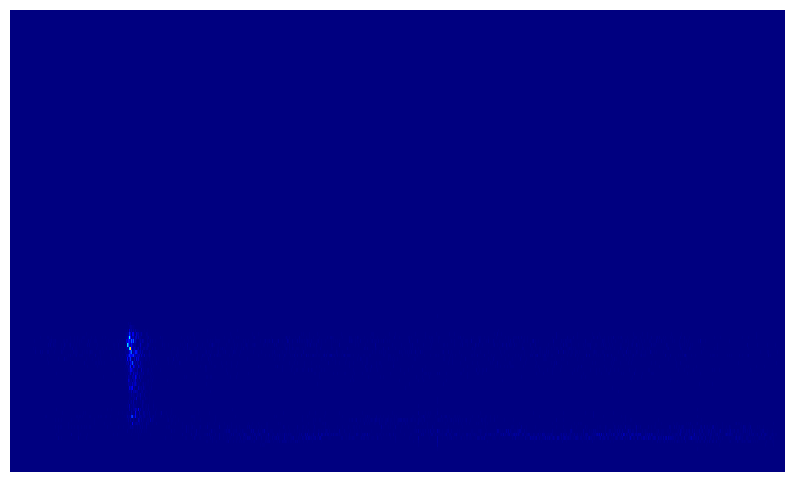

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 1.987043190008889e-11
0.7867201243852799 0.8695327690574146


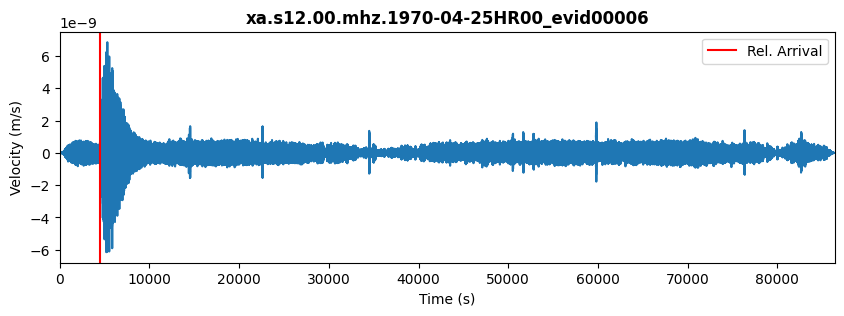

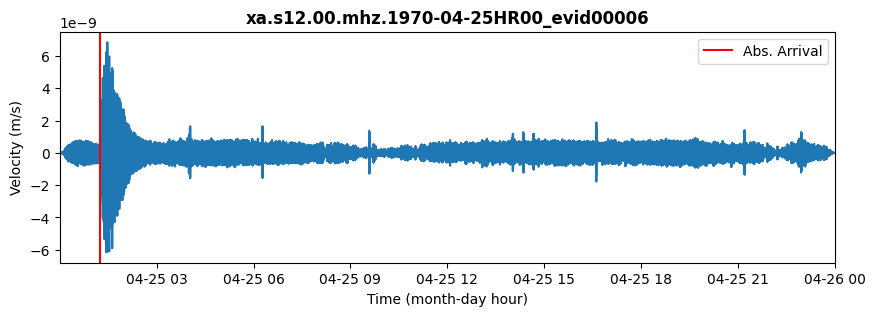

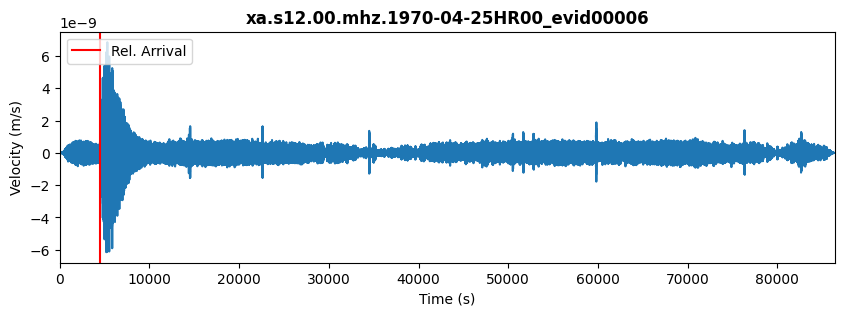

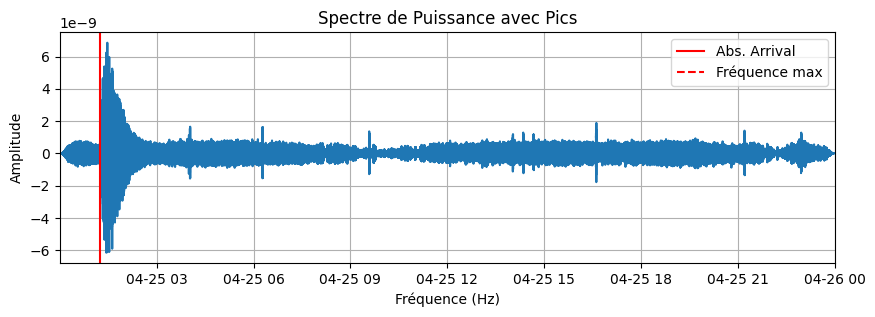

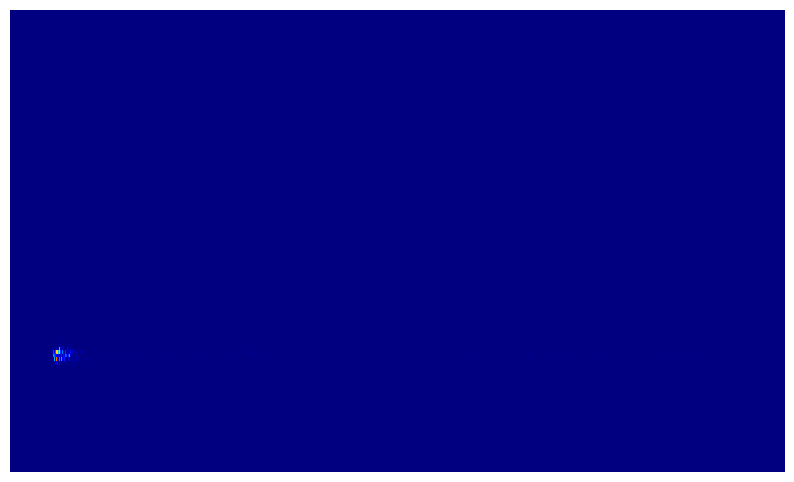

Largeur à mi-hauteur (FWHM) : 0.06521785653141587
Pourcentage basé sur la largeur à mi-hauteur : 7.875391323792489
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 2.4101360036632404e-11
0.7629042500410539 0.8933399631038856


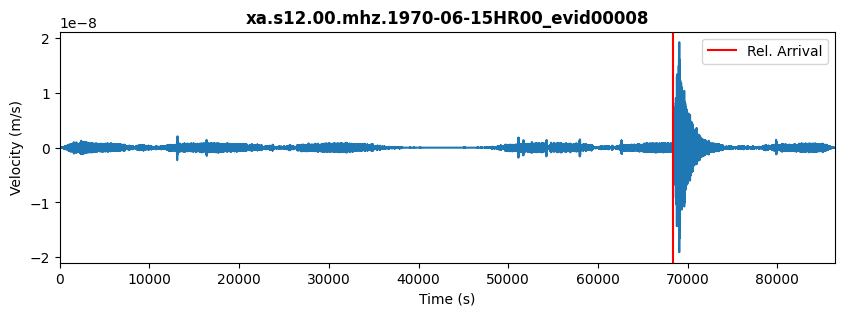

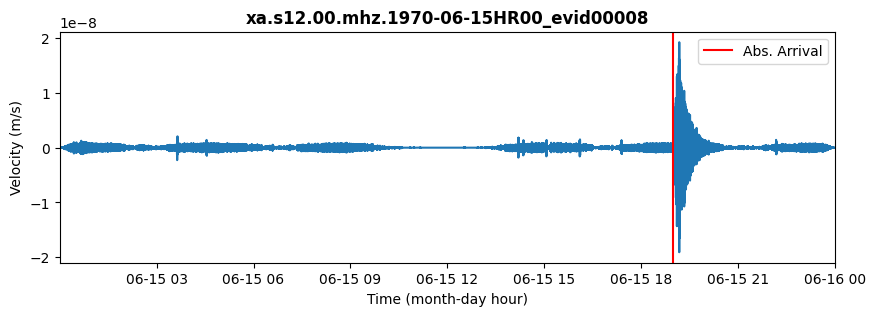

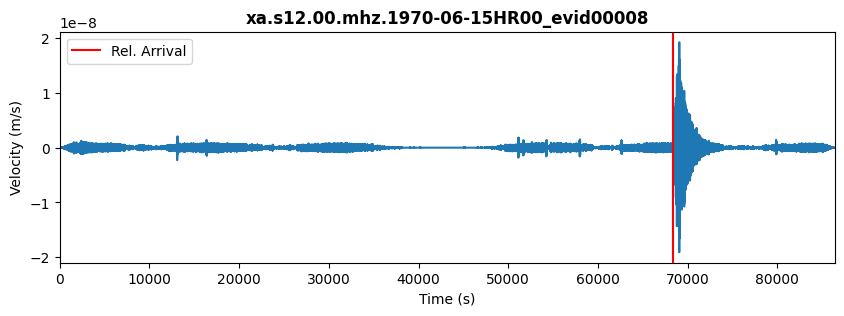

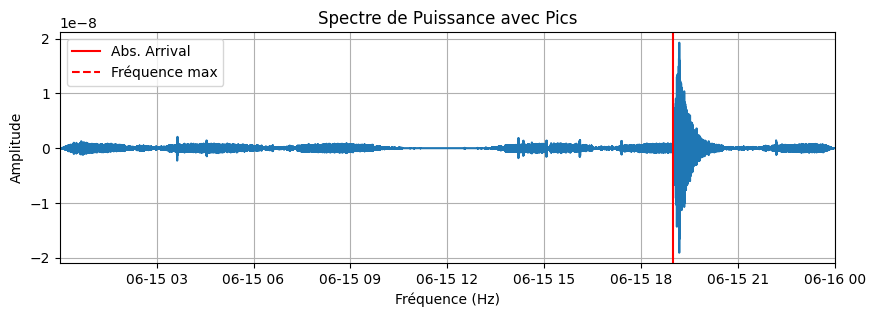

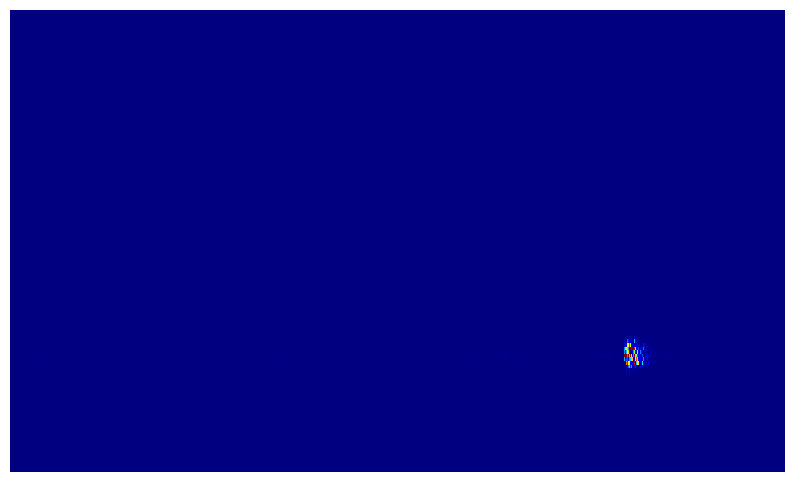

Largeur à mi-hauteur (FWHM) : 0.2974595613990647
Pourcentage basé sur la largeur à mi-hauteur : 35.47363045368594
Fréquence maximale : 0.8385371262956163 Hz
Amplitude maximale : 2.0798530996910268e-11
0.5410775648965516 1.135996687694681


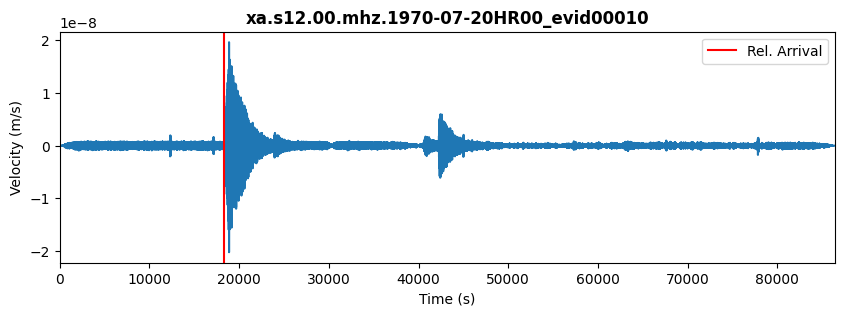

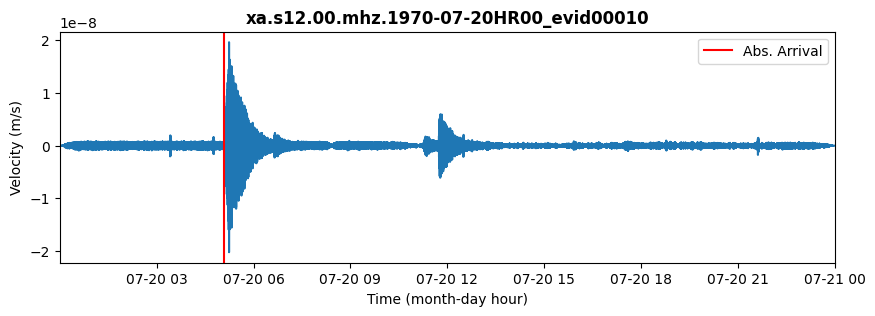

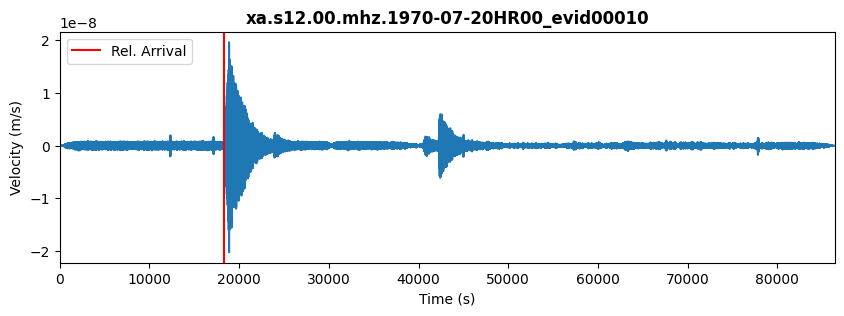

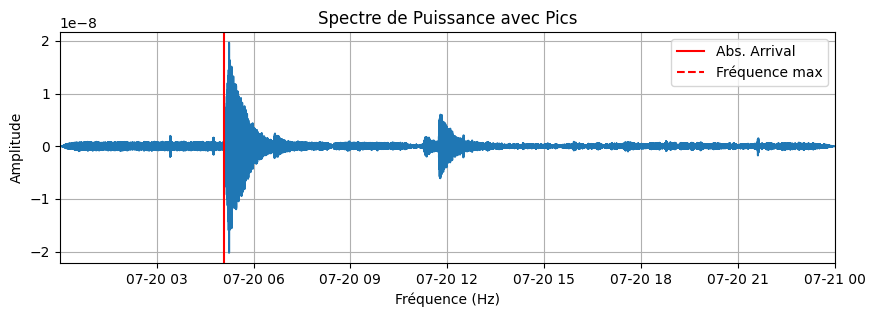

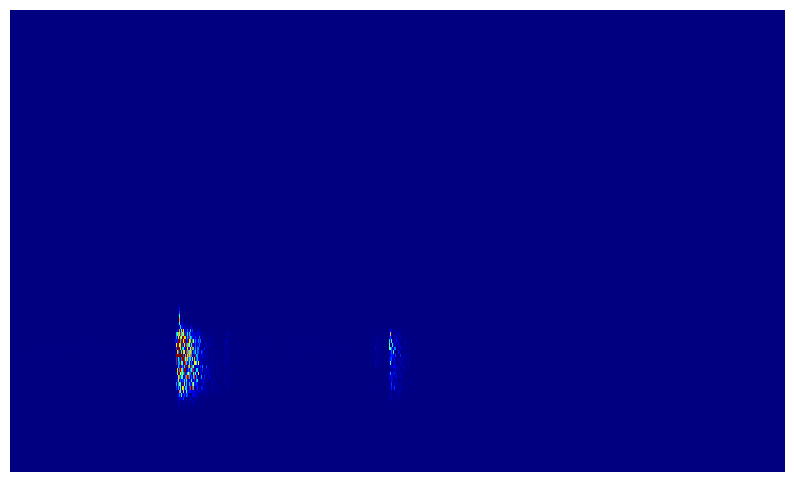

Largeur à mi-hauteur (FWHM) : 0.2624547319028062
Pourcentage basé sur la largeur à mi-hauteur : 31.69259150559726
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 8.530142214233953e-12
0.5656717147983221 1.0905811786039346


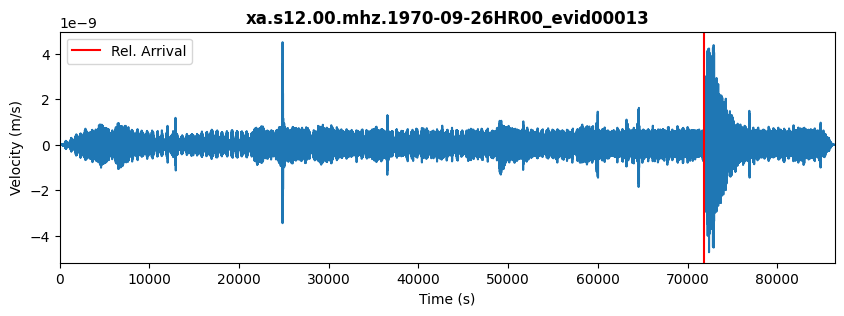

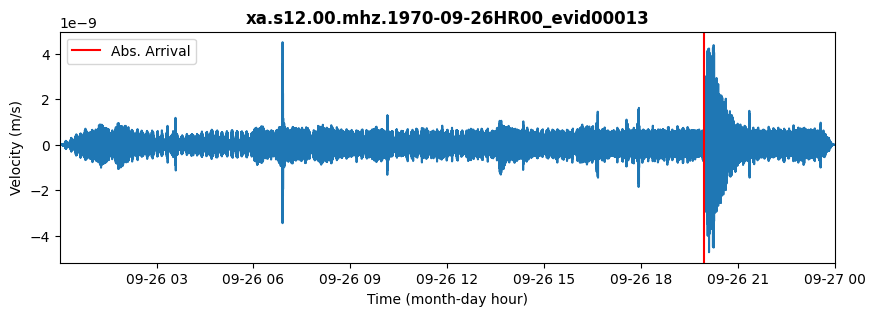

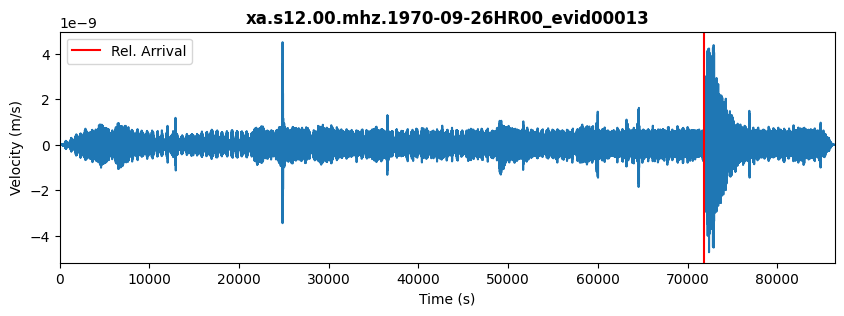

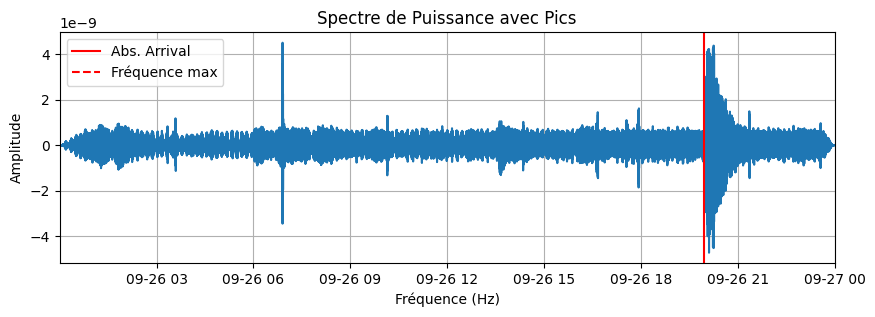

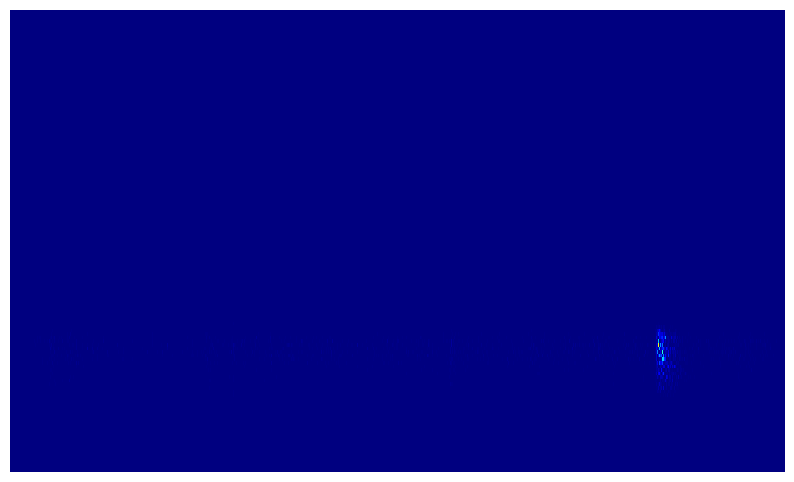

Largeur à mi-hauteur (FWHM) : 1.1573851655510836e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.001397604505873259
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 1.6185552744155227e-11
0.8281090859539737 0.8281322336572847


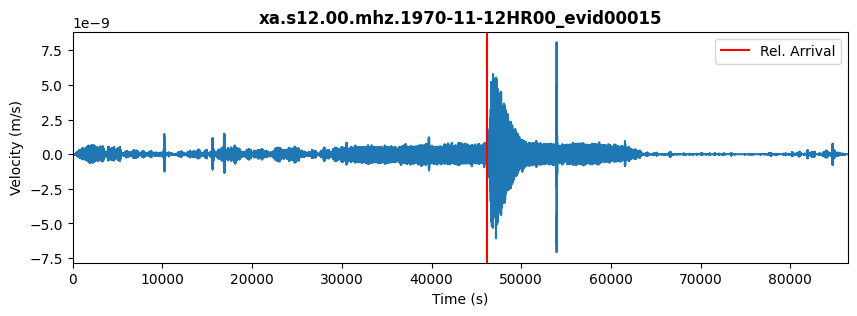

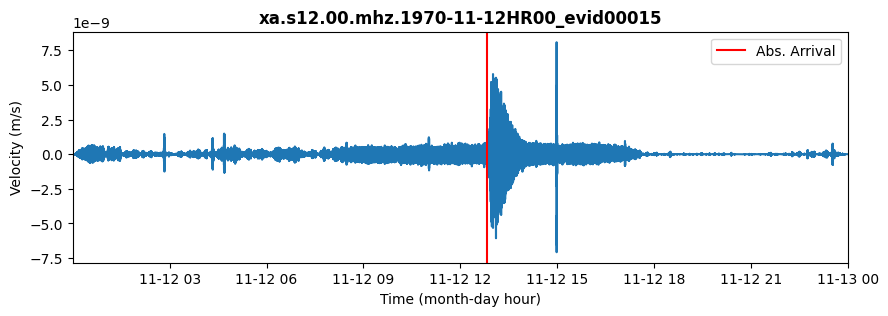

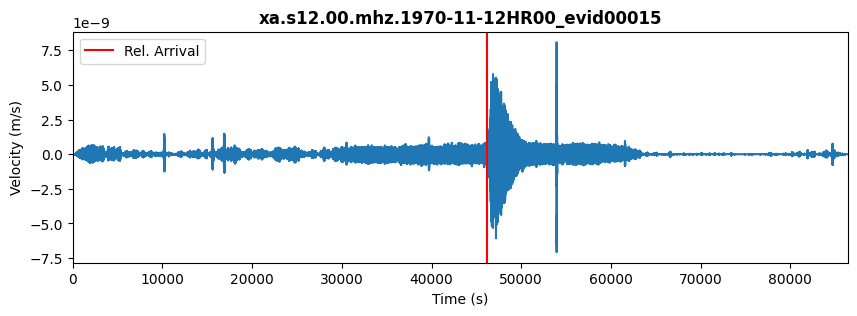

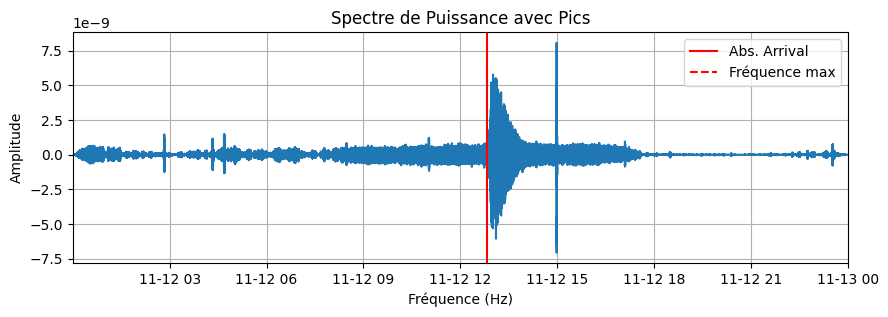

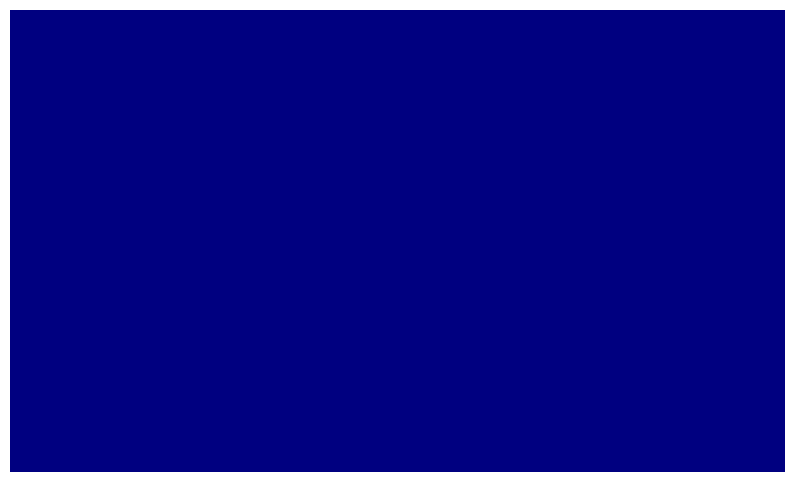

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 7.364216630966001e-11
0.786720124366072 0.8695327690361847


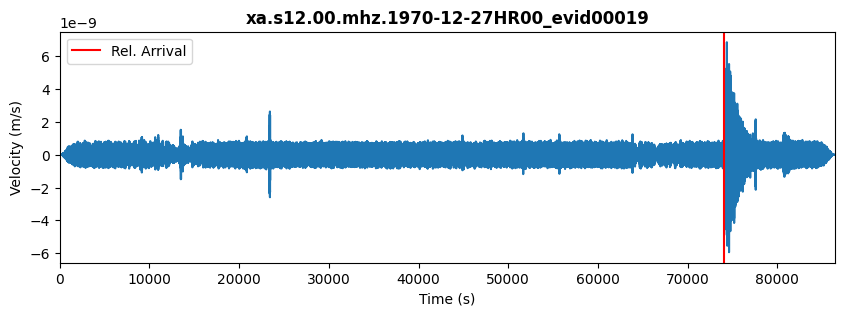

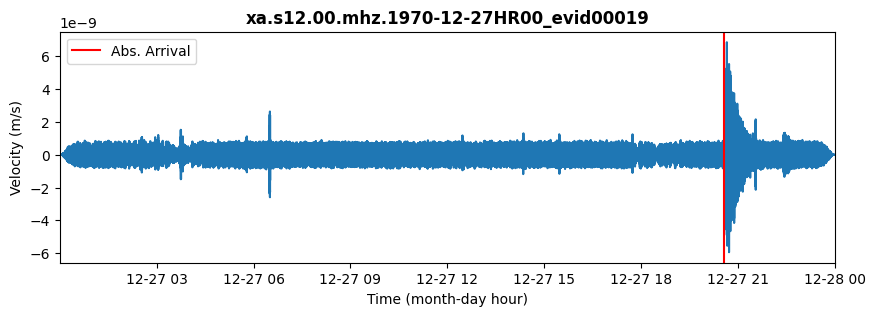

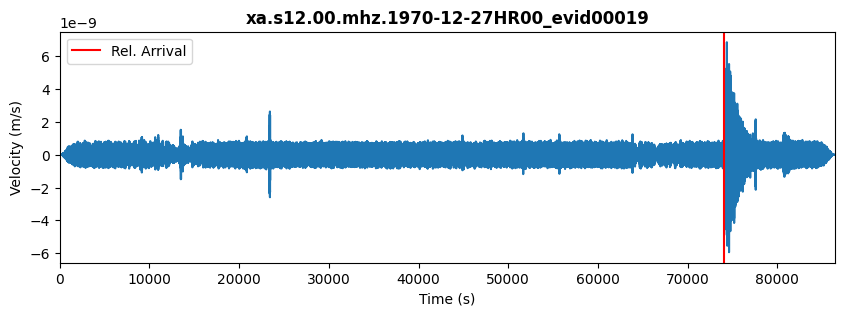

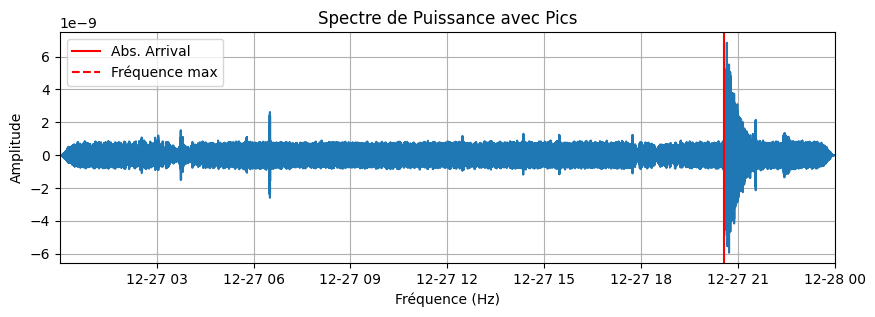

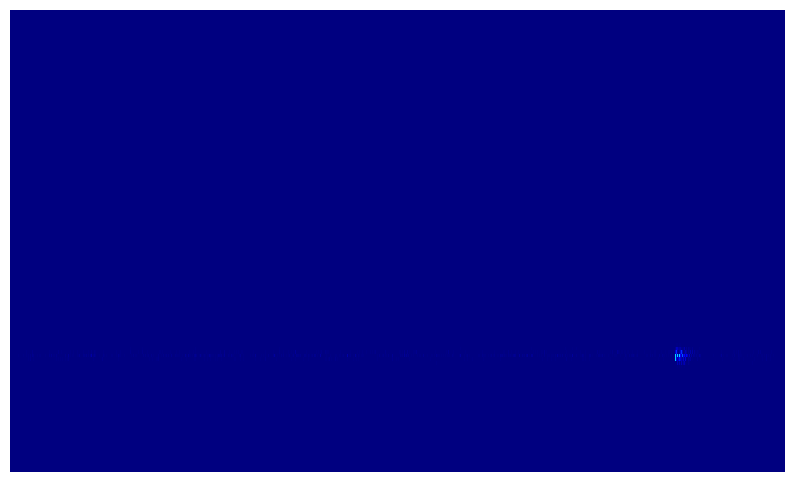

Largeur à mi-hauteur (FWHM) : 0.12880539507451805
Pourcentage basé sur la largeur à mi-hauteur : 15.553940545904311
Fréquence maximale : 0.8281206598056292 Hz
Amplitude maximale : 1.1388486561159096e-11
0.6993152647311112 0.9569260548801473


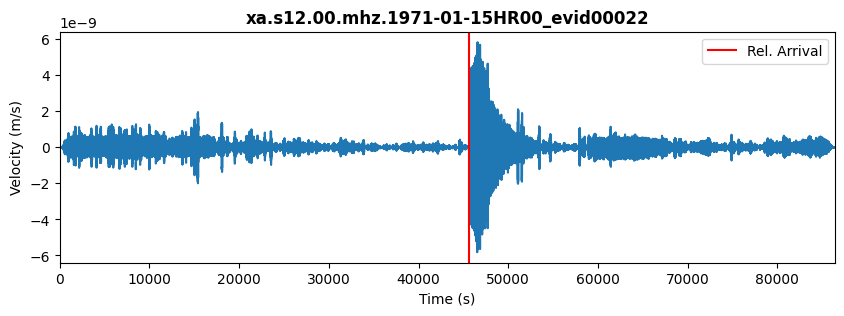

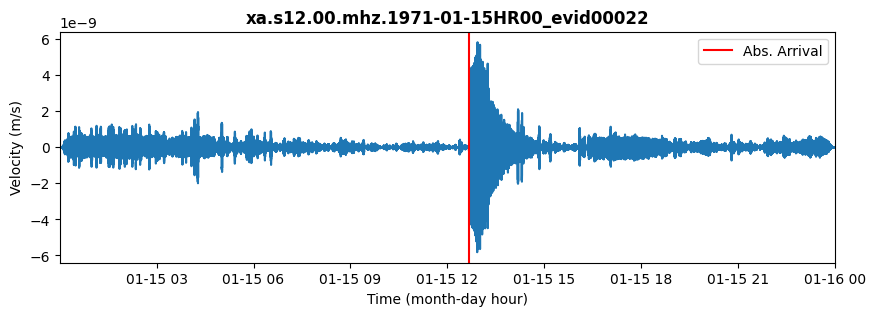

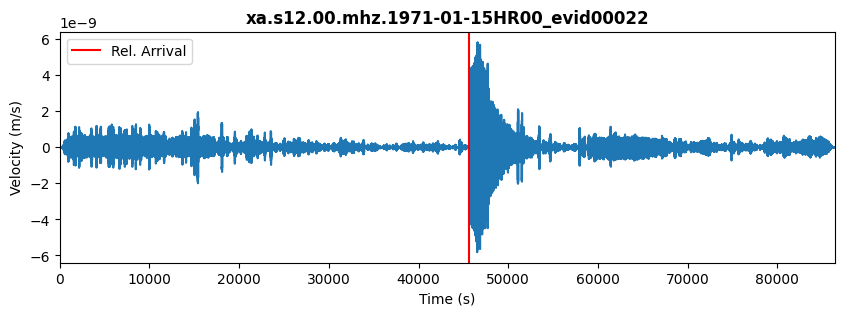

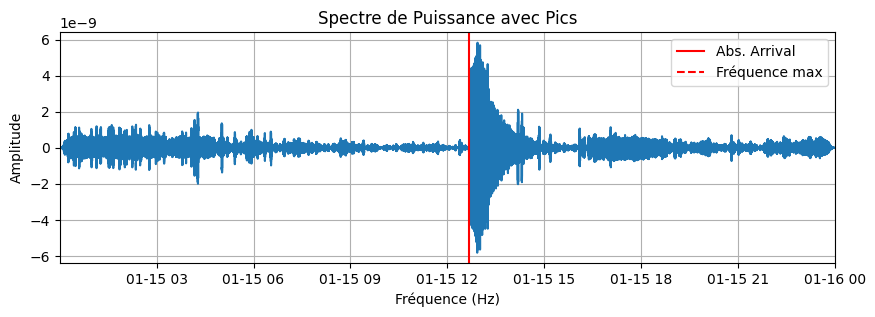

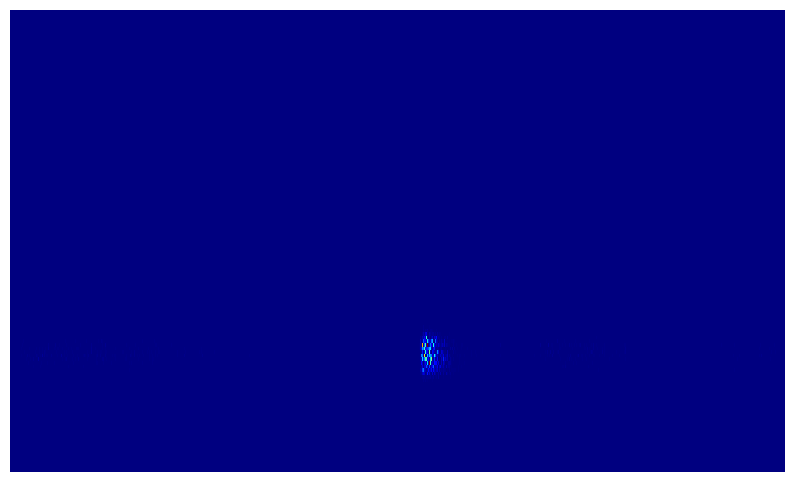

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467011283 Hz
Amplitude maximale : 1.0223674957196767e-10
0.786720124366072 0.8695327690361847


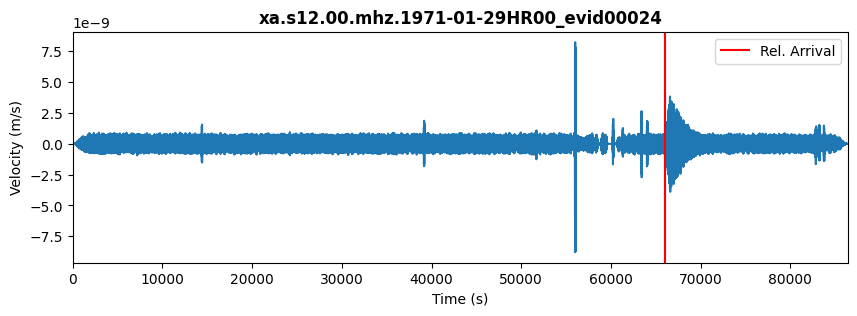

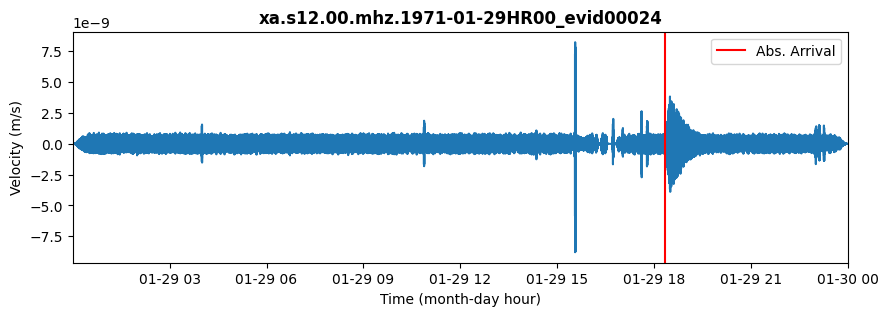

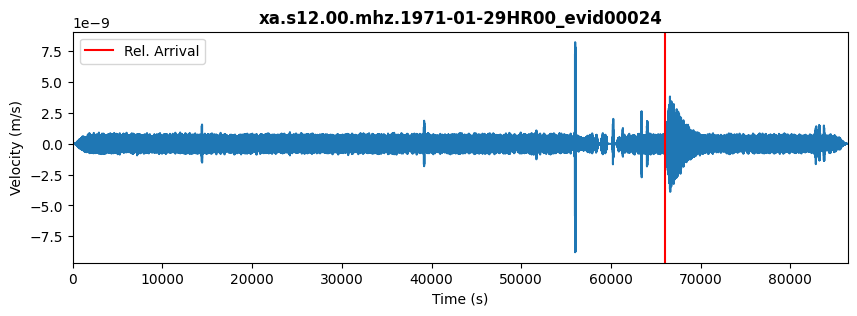

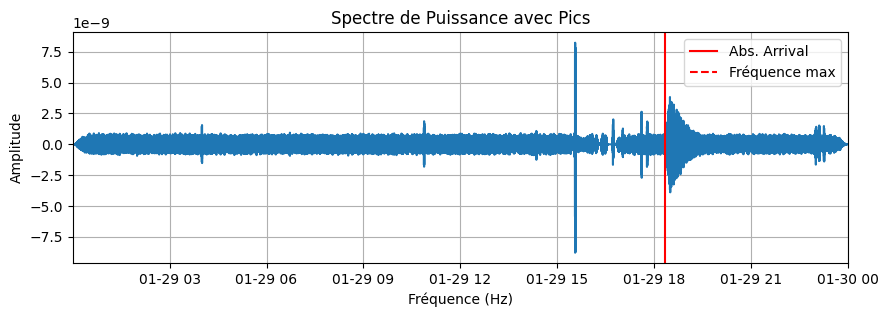

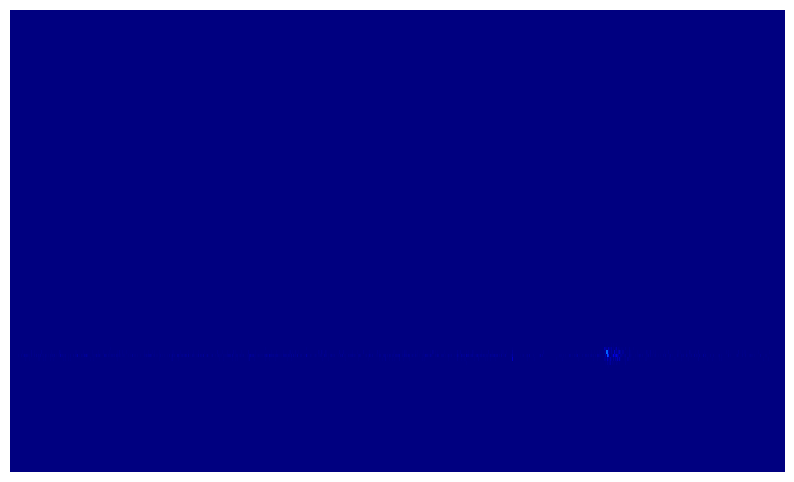

Largeur à mi-hauteur (FWHM) : 1.1573528152952761e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.0013975654410039455
Fréquence maximale : 0.8281206599269427 Hz
Amplitude maximale : 7.68709718898875e-11
0.8281090863987898 0.8281322334550957


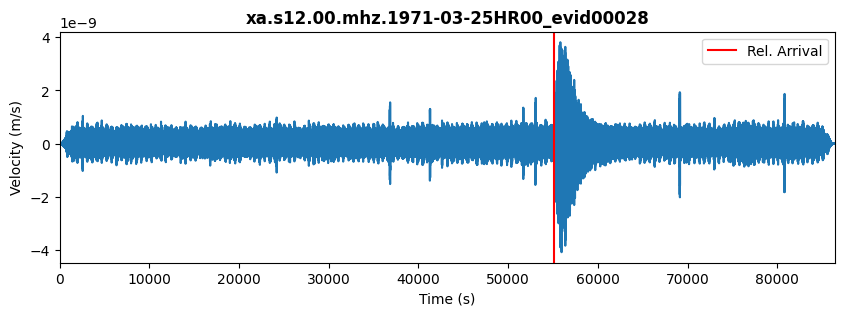

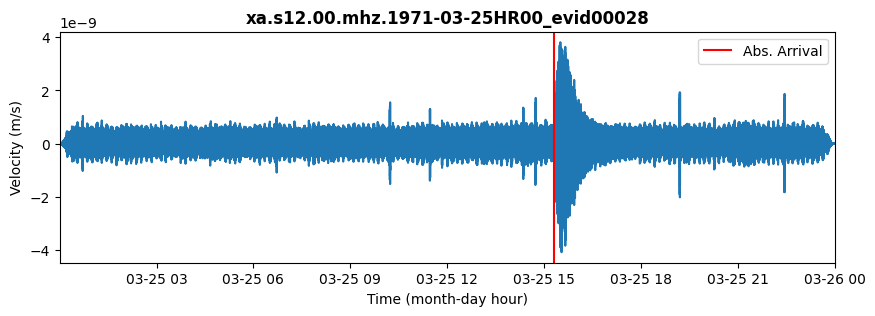

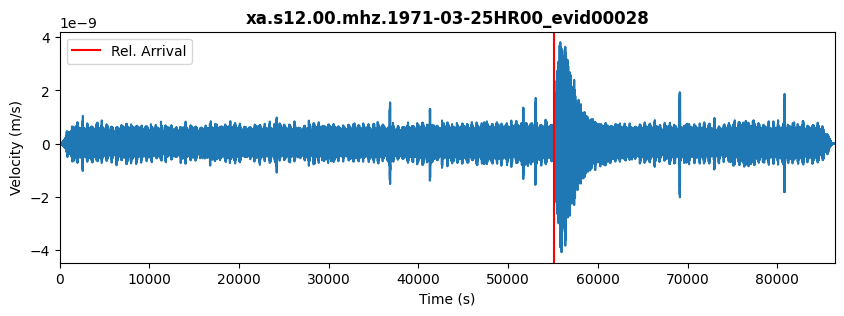

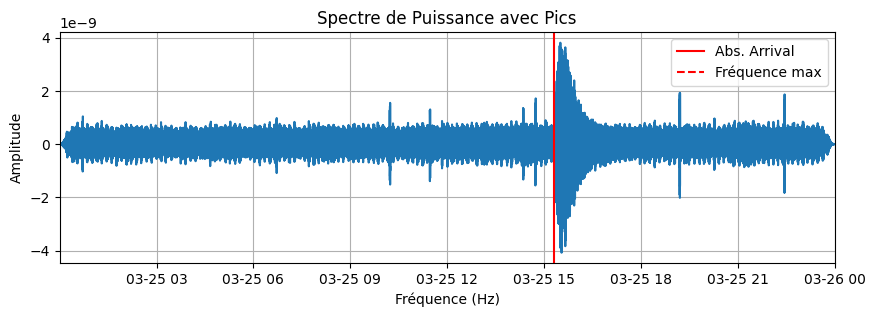

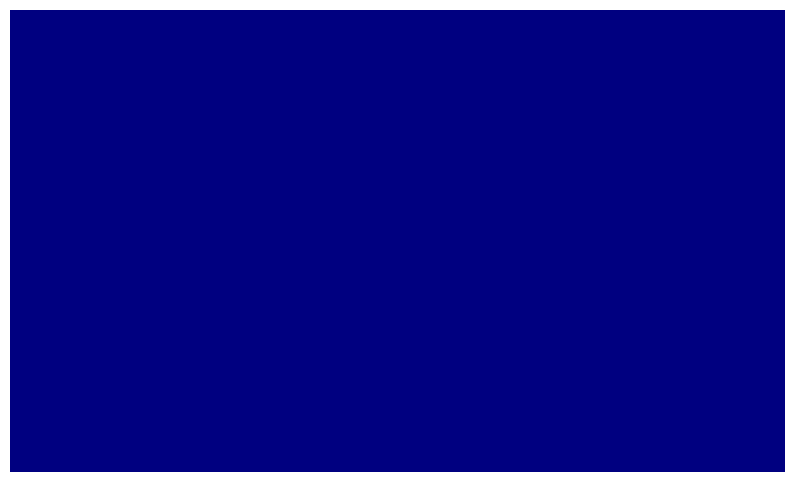

Largeur à mi-hauteur (FWHM) : 0.5968909520664969
Pourcentage basé sur la largeur à mi-hauteur : 72.07764982110912
Fréquence maximale : 0.8281221065724698 Hz
Amplitude maximale : 2.0682677437218243e-11
0.23123115450597287 1.4250130586389667


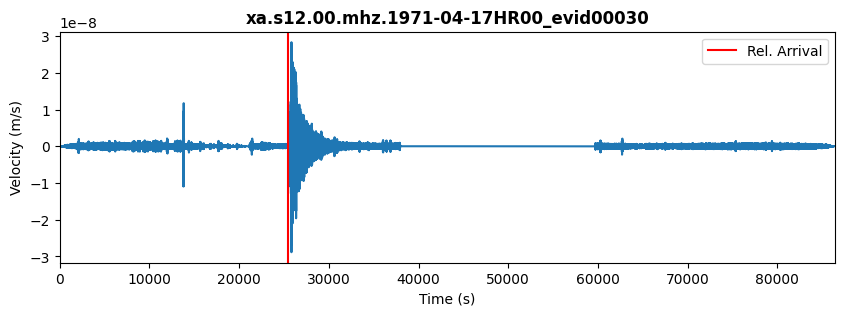

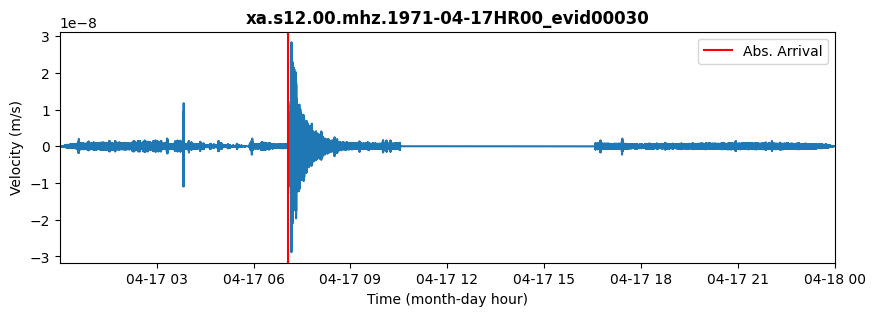

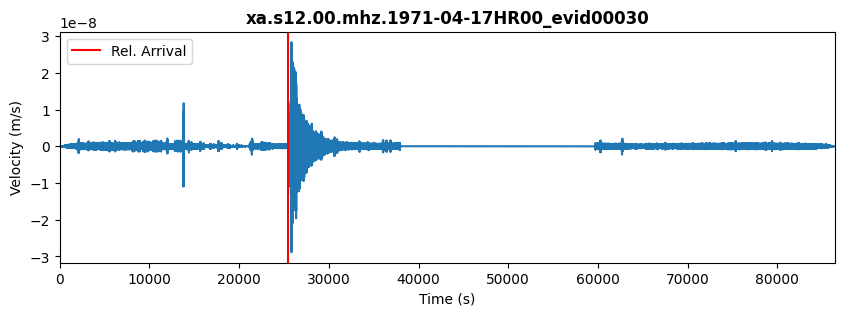

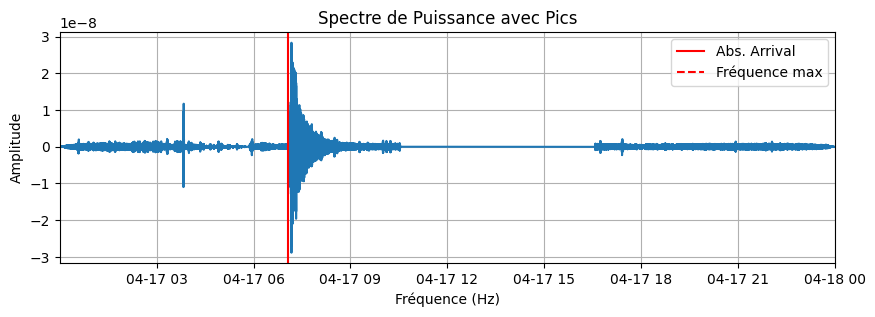

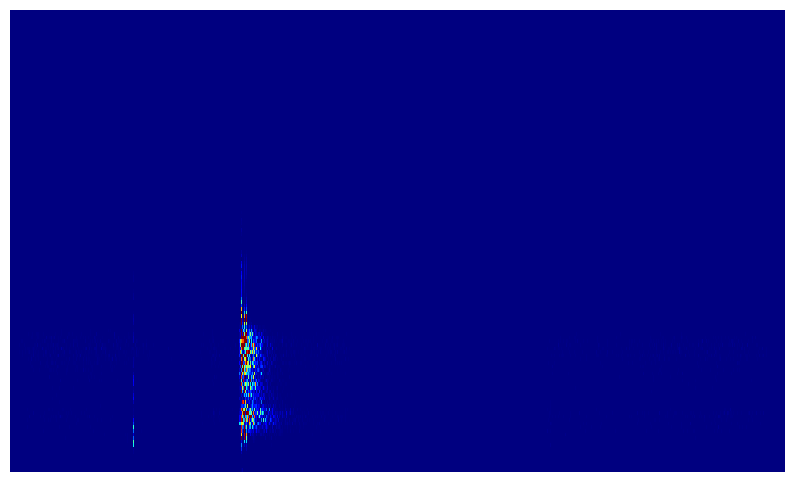

Largeur à mi-hauteur (FWHM) : 0.611960108803701
Pourcentage basé sur la largeur à mi-hauteur : 66.09910991099112
Fréquence maximale : 0.925822011261218 Hz
Amplitude maximale : 1.3261211488336554e-11
0.313861902457517 1.5377821200649189


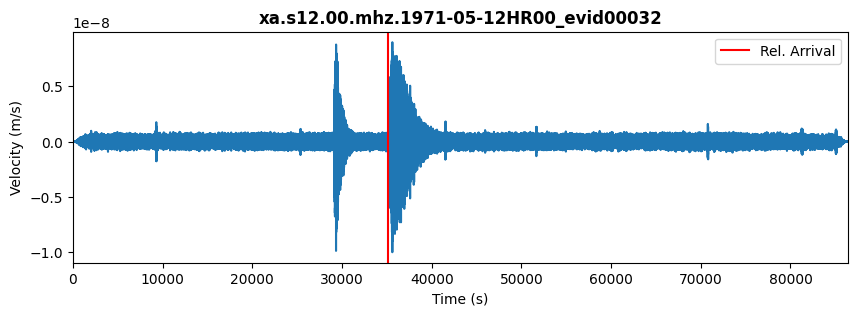

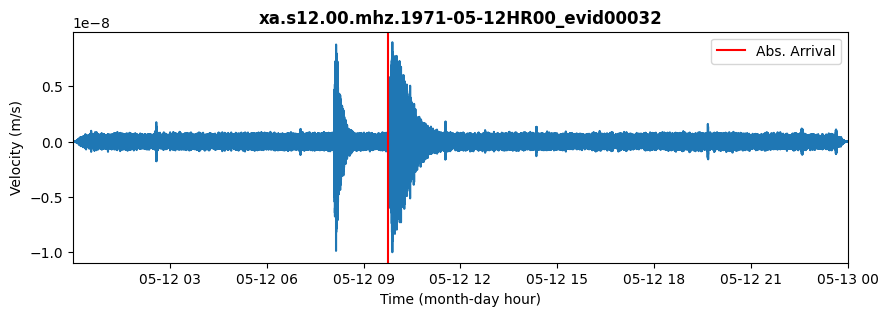

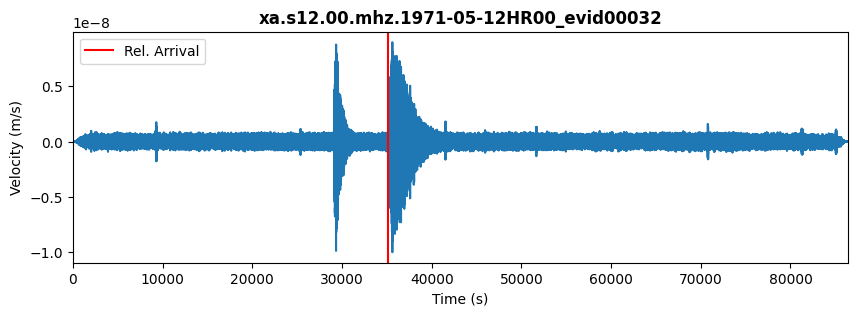

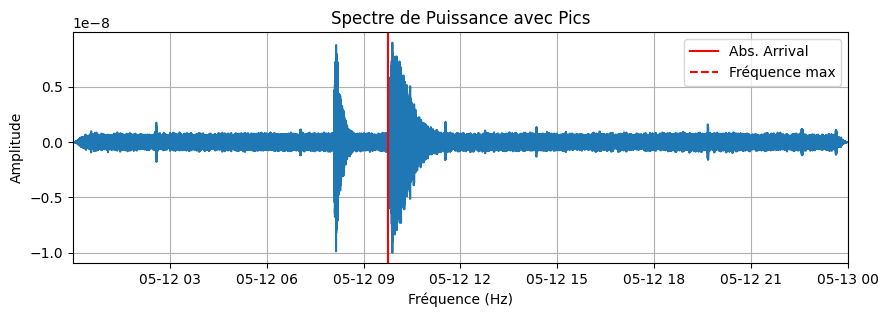

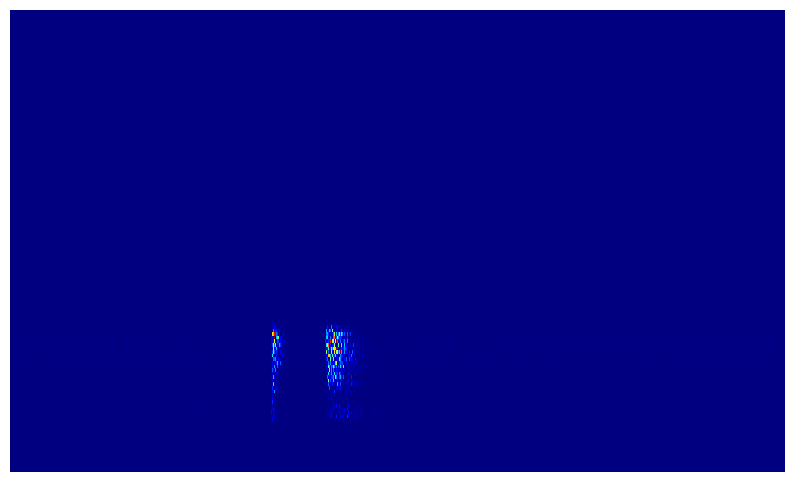

Largeur à mi-hauteur (FWHM) : 0.7984054187200724
Pourcentage basé sur la largeur à mi-hauteur : 83.73490319839777
Fréquence maximale : 0.9534917796804112 Hz
Amplitude maximale : 9.079384410086023e-11
0.1550863609603388 1.7518971984004836


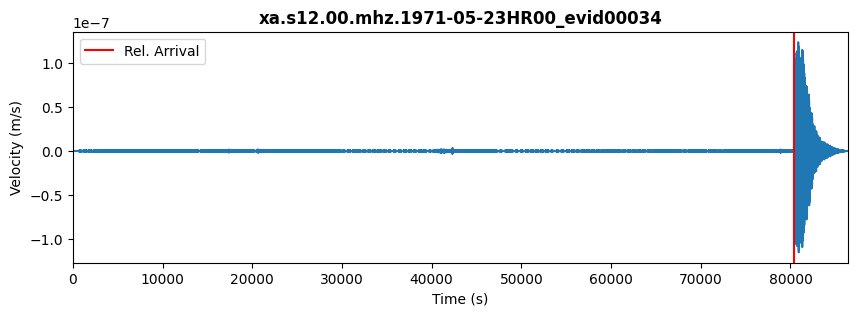

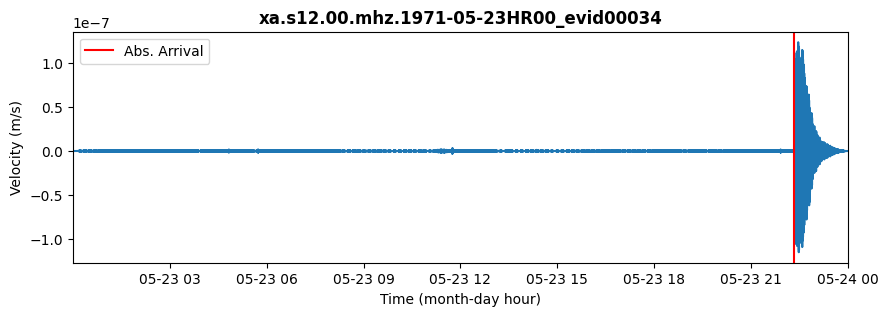

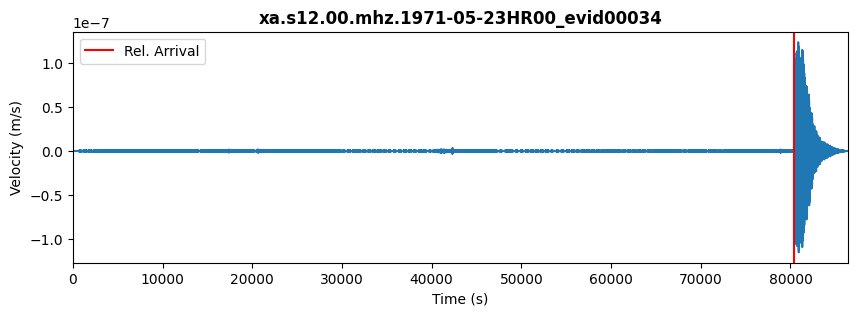

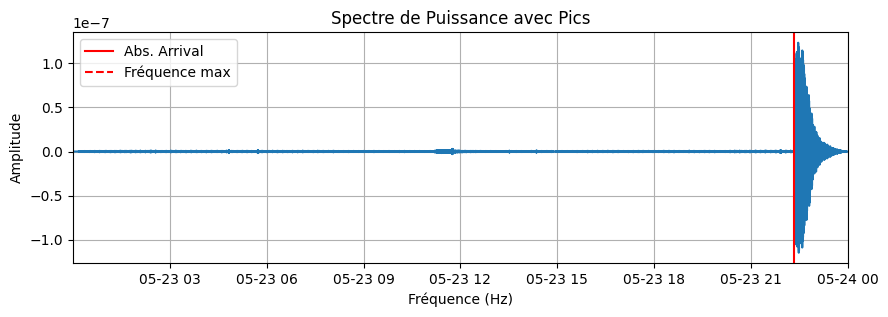

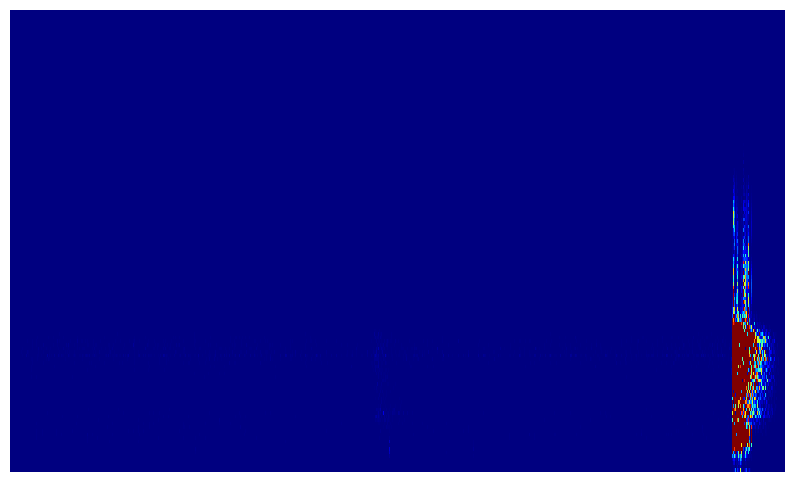

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 4.513222878348696e-11
0.7867201244236975 0.8695327690998763


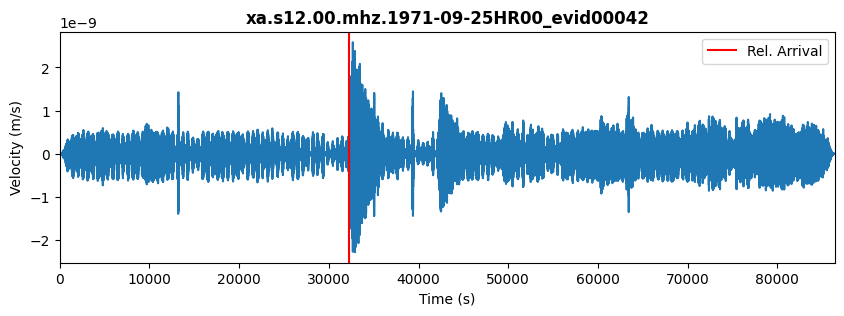

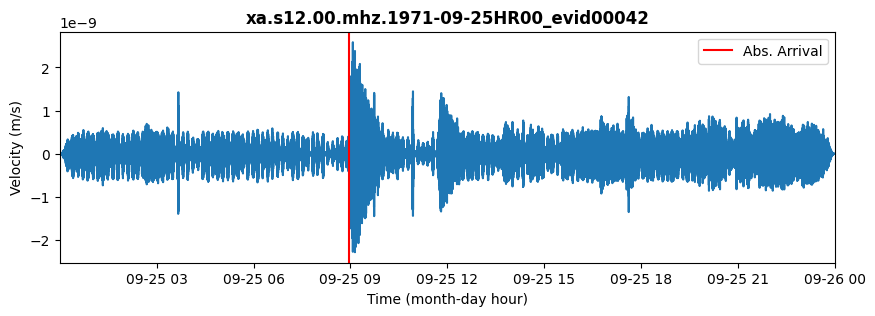

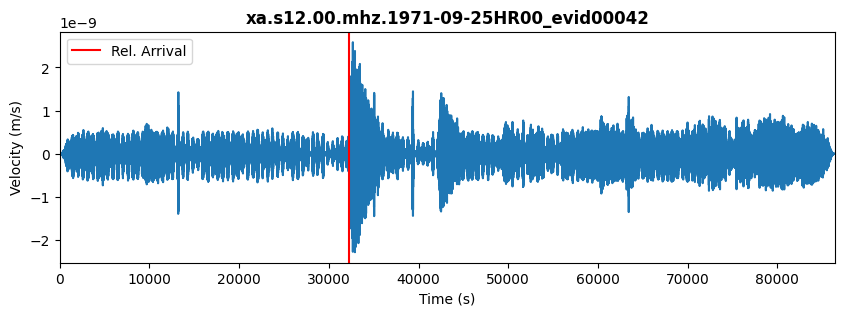

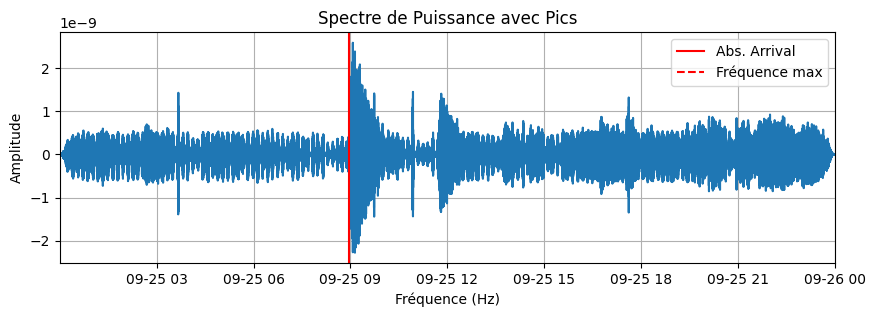

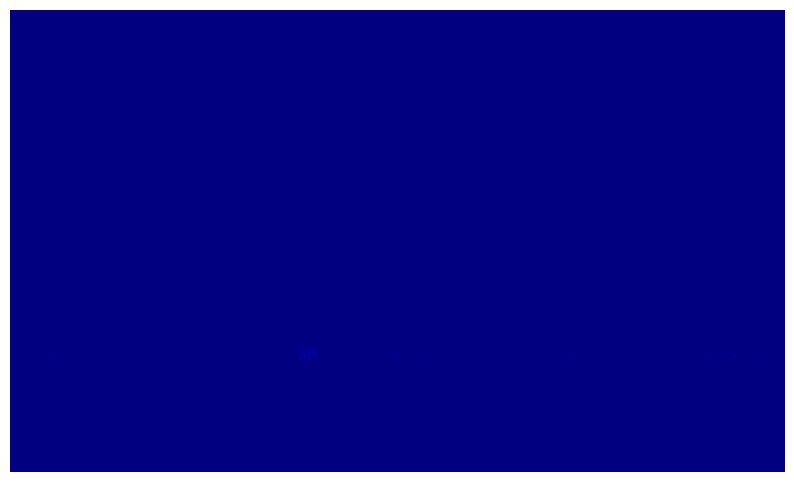

Largeur à mi-hauteur (FWHM) : 0.23407448300922962
Pourcentage basé sur la largeur à mi-hauteur : 28.26554856743536
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 4.8916215176998566e-11
0.5940519637525573 1.0622009297710164


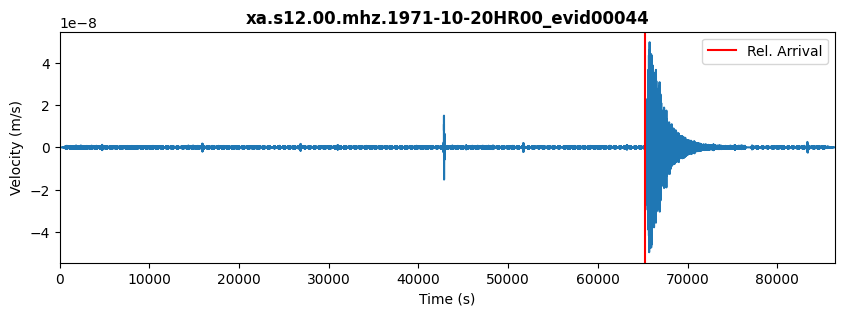

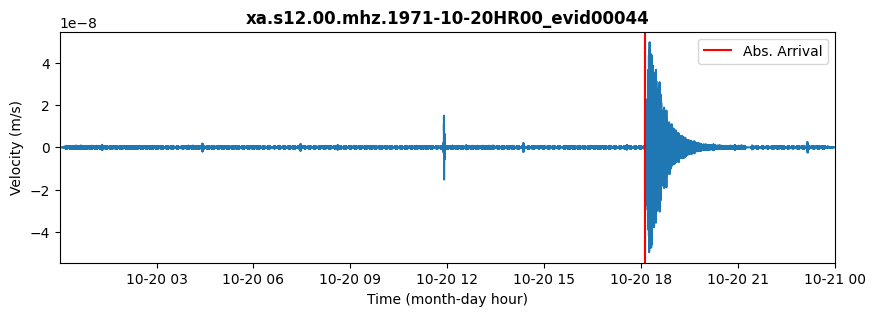

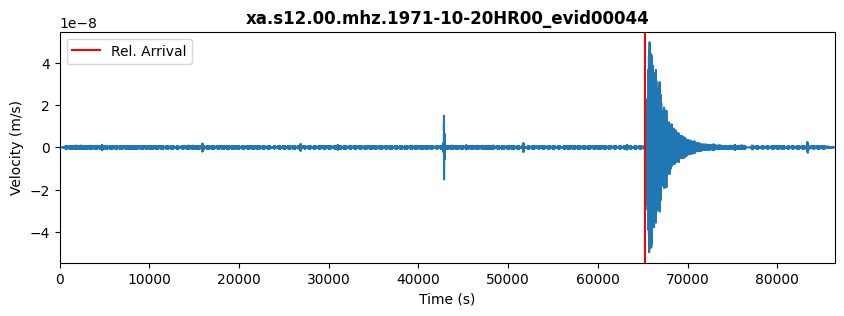

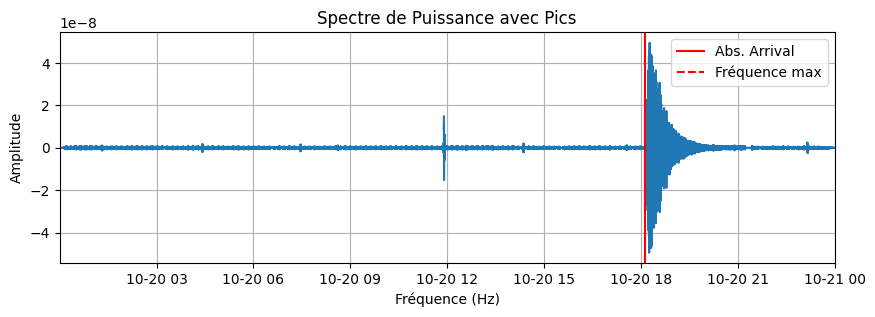

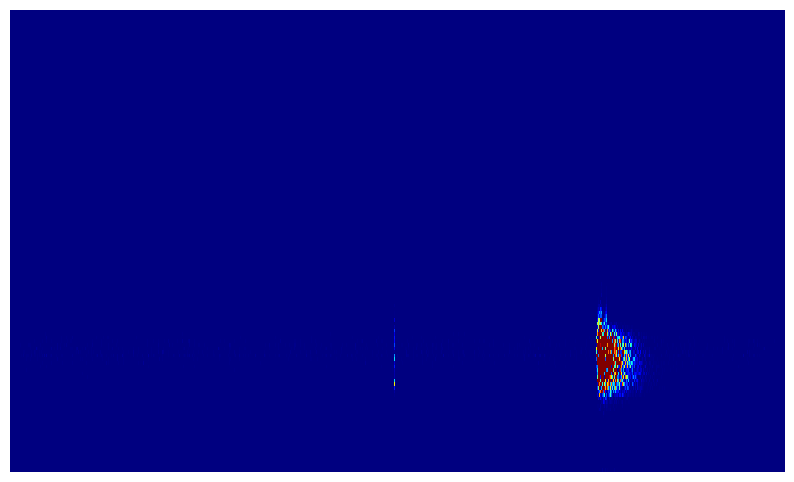

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 7.330874198386505e-11
0.7867201244236975 0.8695327690998763


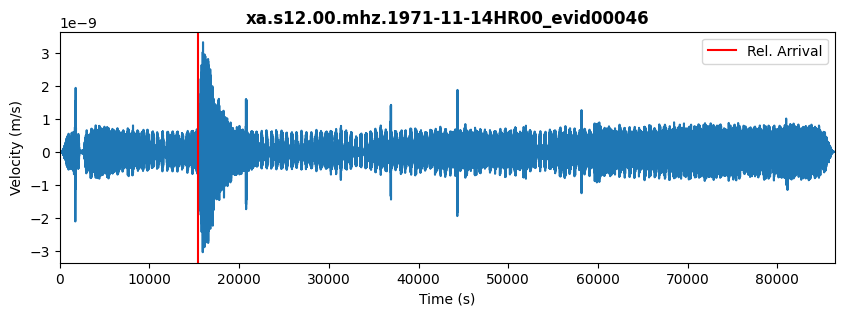

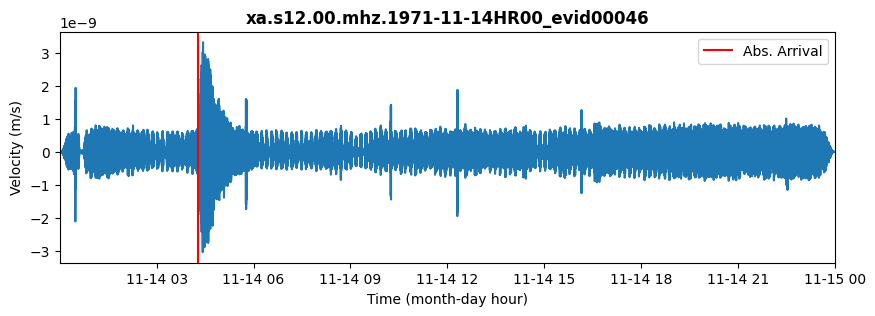

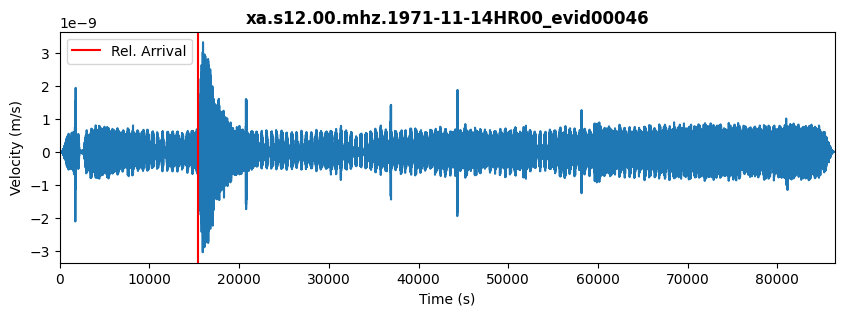

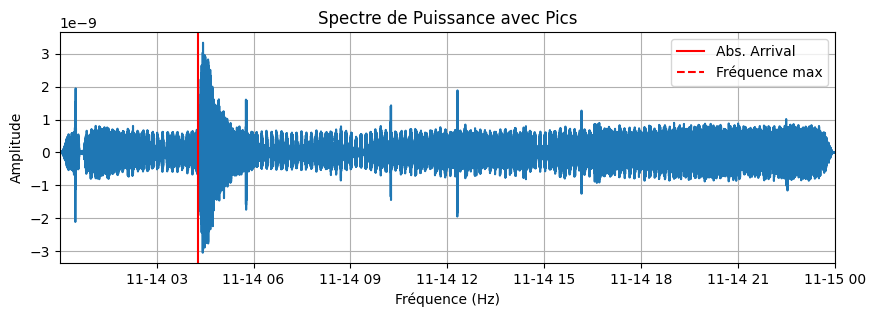

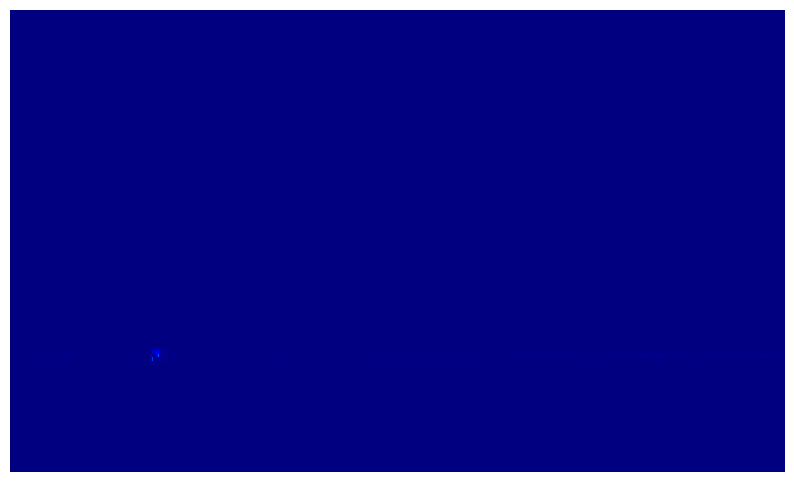

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 3.374260777472386e-11
0.7867201244236975 0.8695327690998763


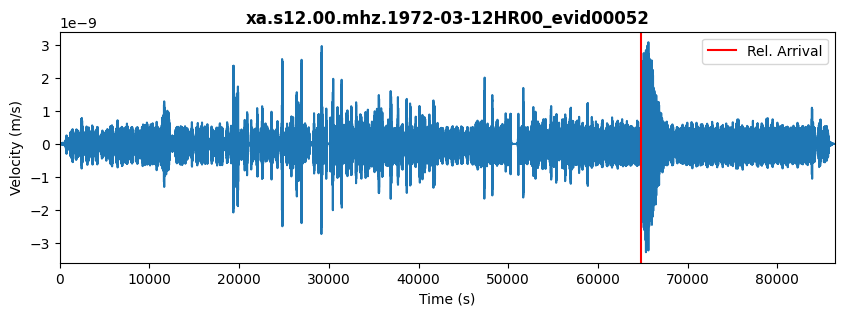

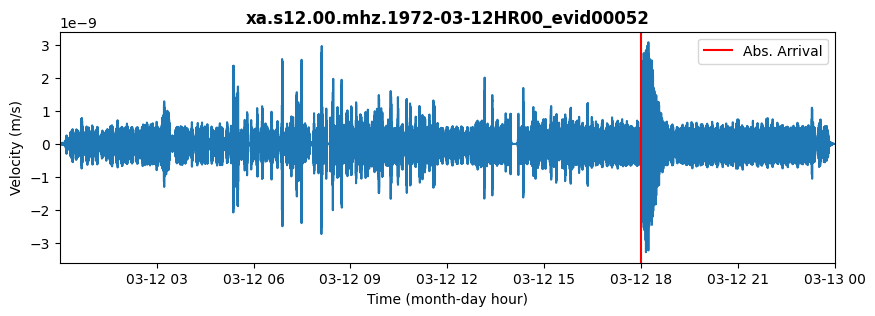

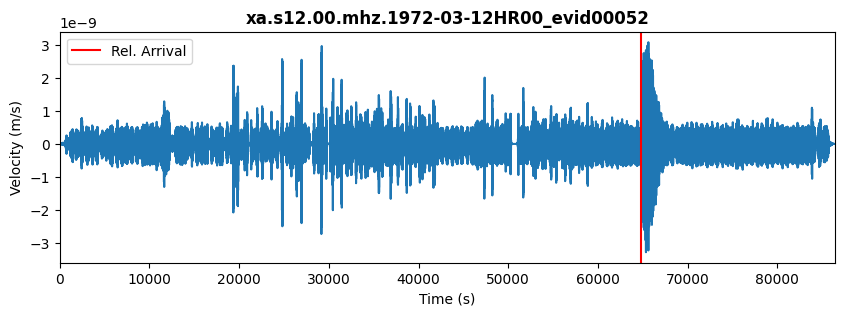

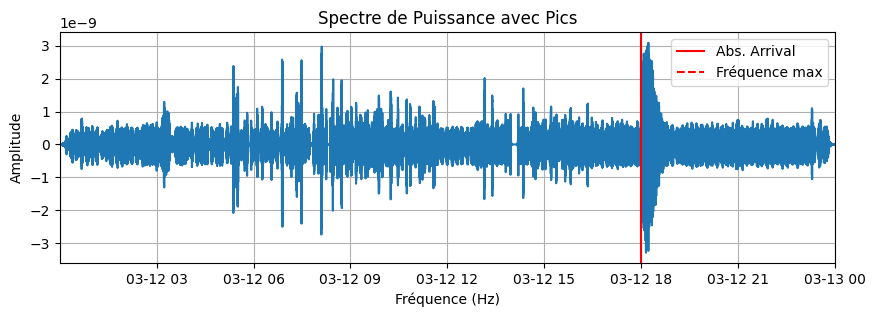

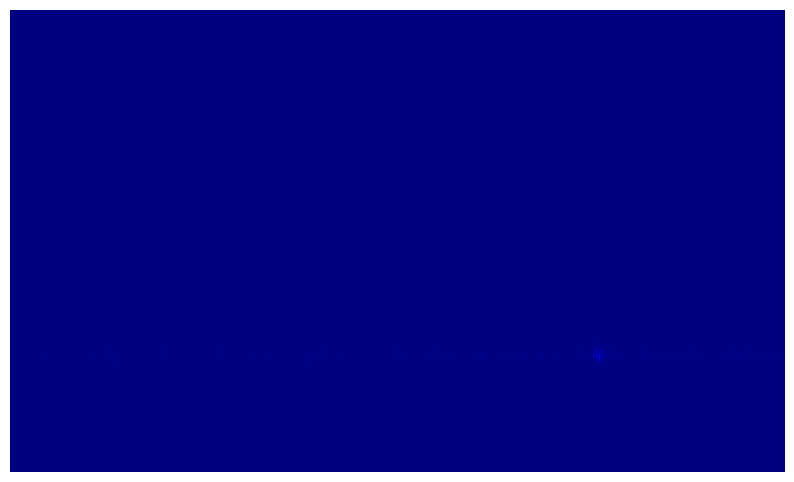

Largeur à mi-hauteur (FWHM) : 0.9463905422616044
Pourcentage basé sur la largeur à mi-hauteur : 875.1792786043028
Fréquence maximale : 0.10813676299224842 Hz
Amplitude maximale : 8.737487930278064e-12
0.0001 1.0545273052538529


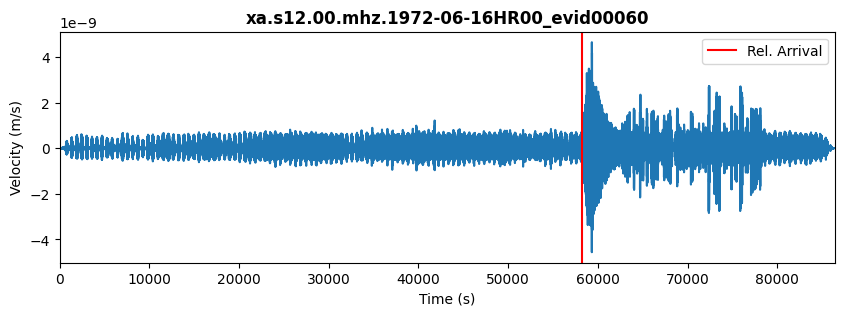

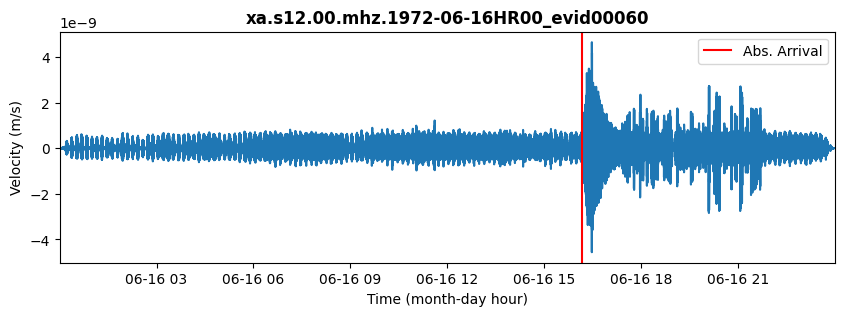

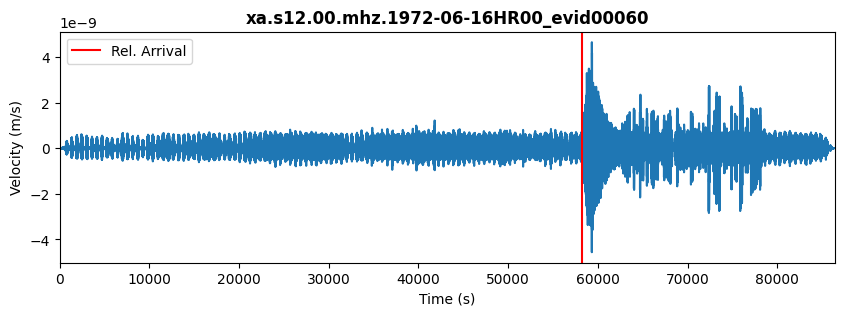

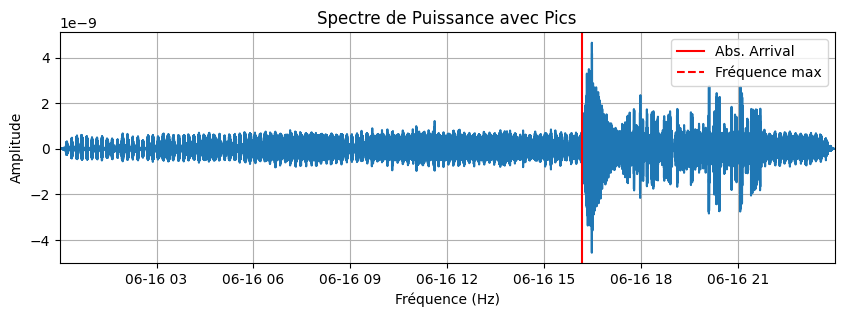

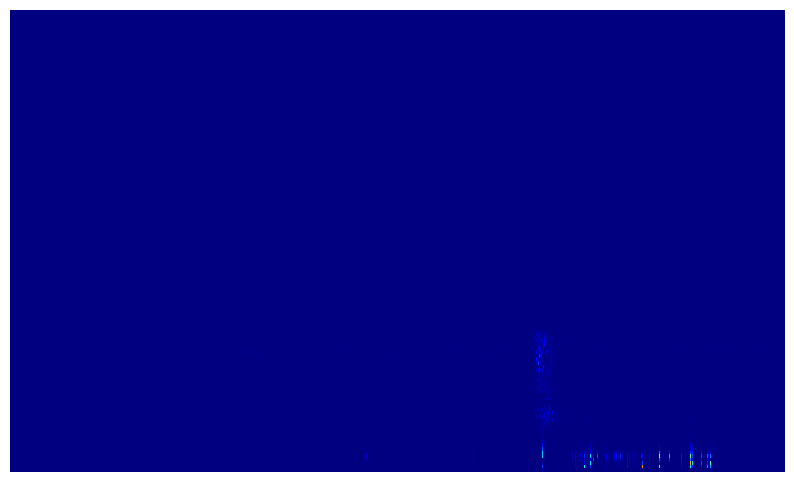

Largeur à mi-hauteur (FWHM) : 0.5663551561061428
Pourcentage basé sur la largeur à mi-hauteur : 133.15102040816328
Fréquence maximale : 0.4253479653178989 Hz
Amplitude maximale : 4.342228947516843e-11
0.0001 0.9917031214240417


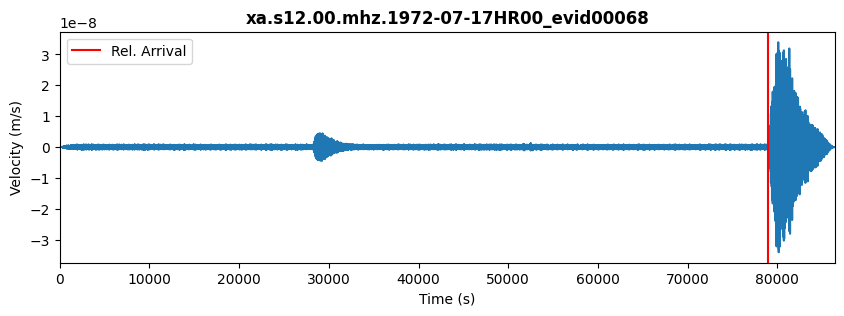

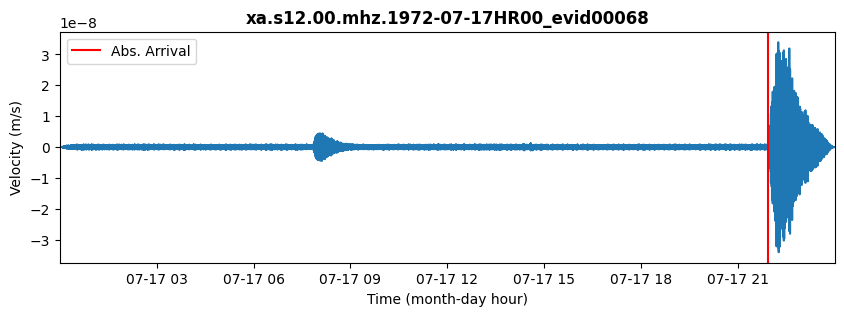

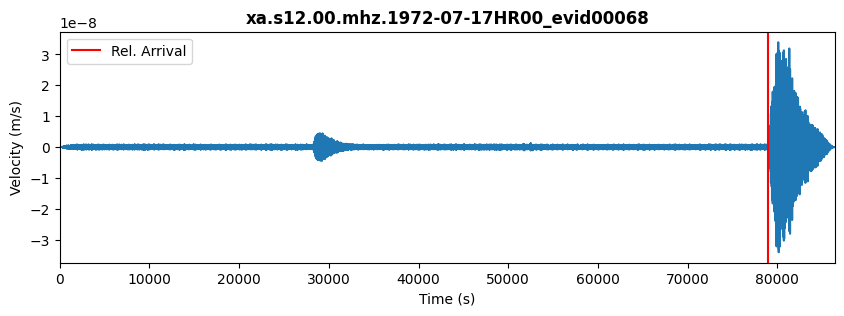

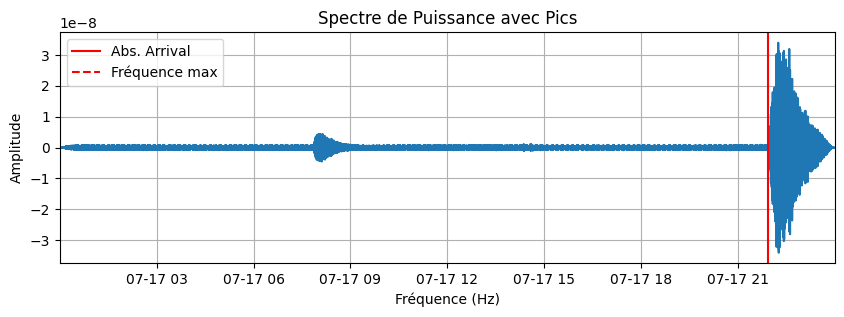

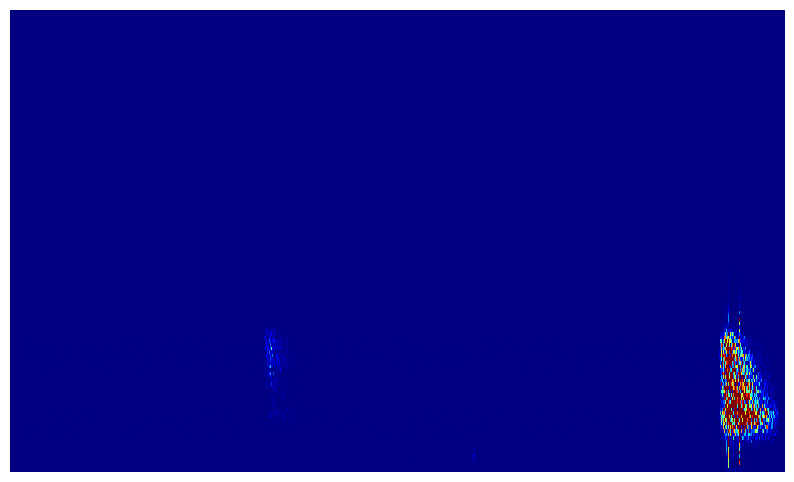

Largeur à mi-hauteur (FWHM) : 0.1191635439322869
Pourcentage basé sur la largeur à mi-hauteur : 14.38953488372093
Fréquence maximale : 0.8281264467213473 Hz
Amplitude maximale : 2.1370267329791545e-11
0.7089629027890604 0.9472899906536342


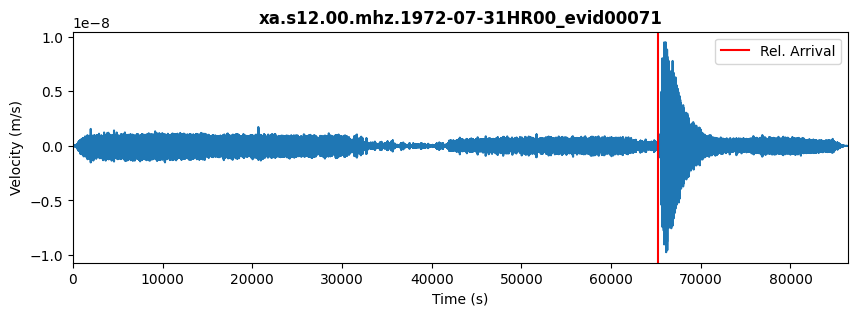

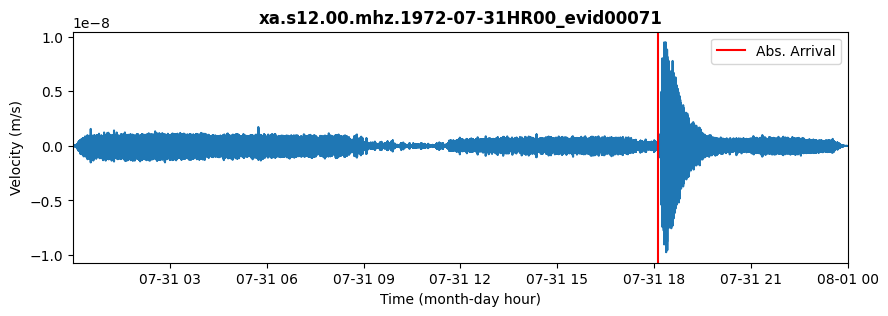

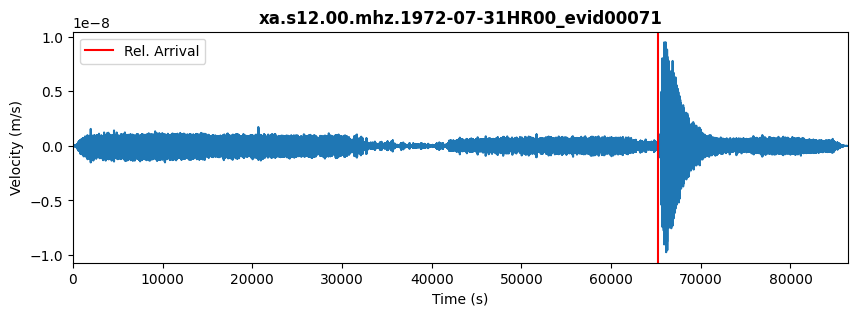

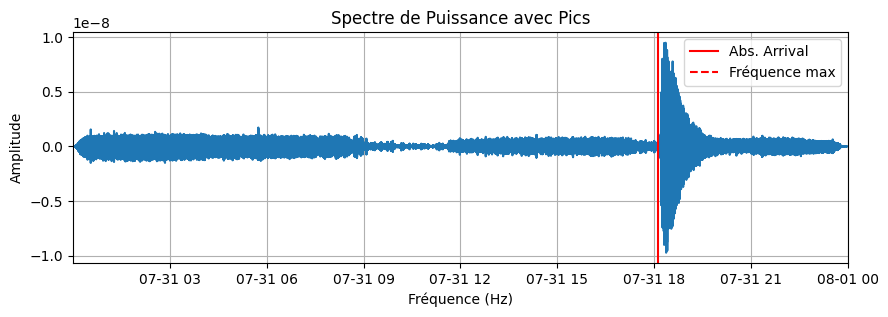

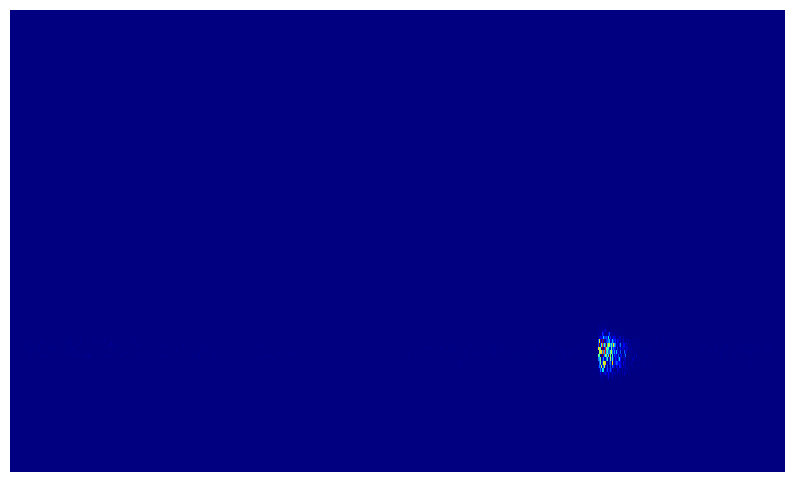

Largeur à mi-hauteur (FWHM) : 0.0
Pourcentage basé sur la largeur à mi-hauteur : 5
Fréquence maximale : 0.8281264467617869 Hz
Amplitude maximale : 6.682949026762927e-11
0.7867201244236975 0.8695327690998763


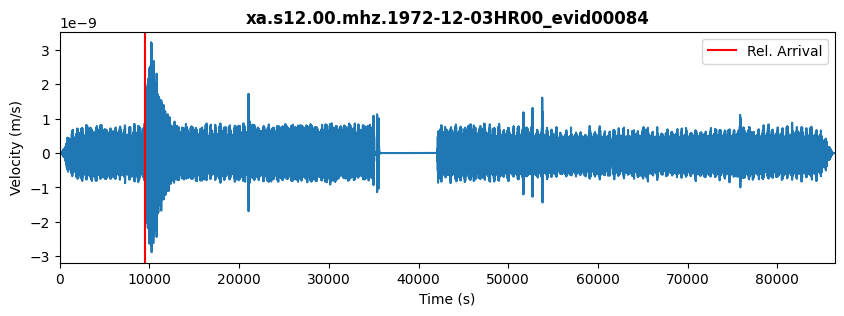

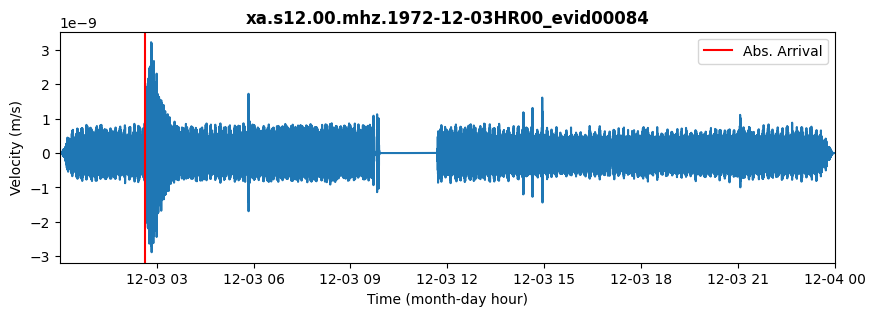

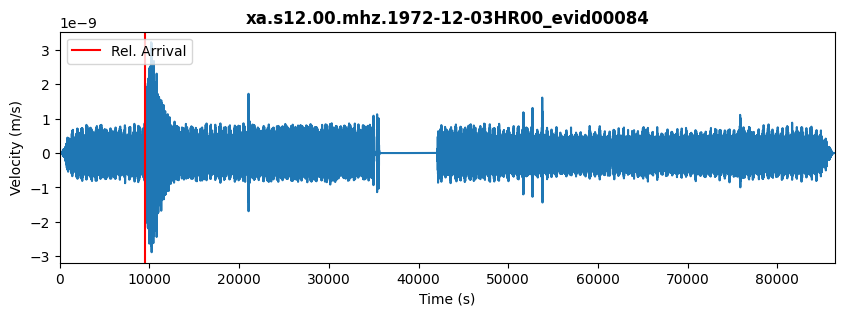

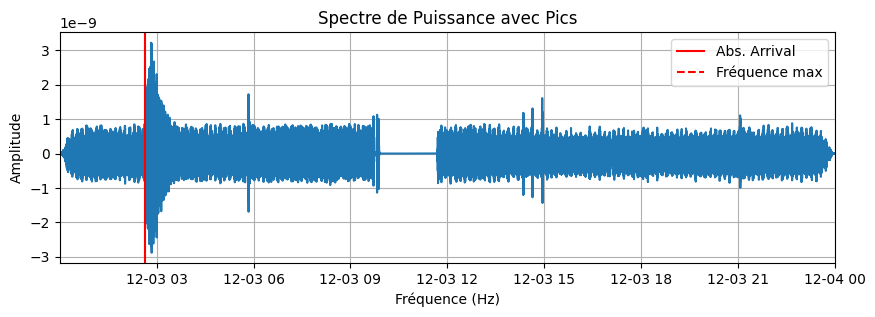

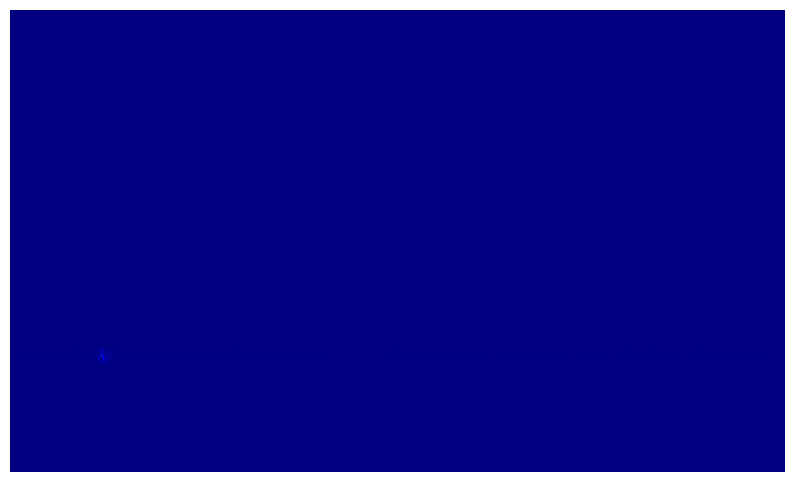

Largeur à mi-hauteur (FWHM) : 5.78708758811608e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.006988217864679524
Fréquence maximale : 0.8281206596843089 Hz
Amplitude maximale : 1.6538635320882833e-11
0.8280627888084278 0.8281785305601901


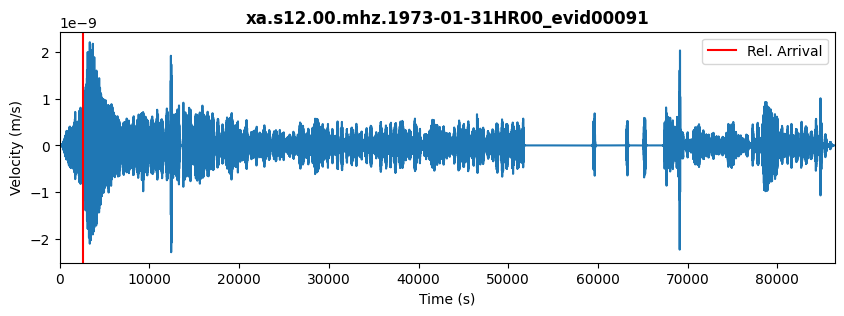

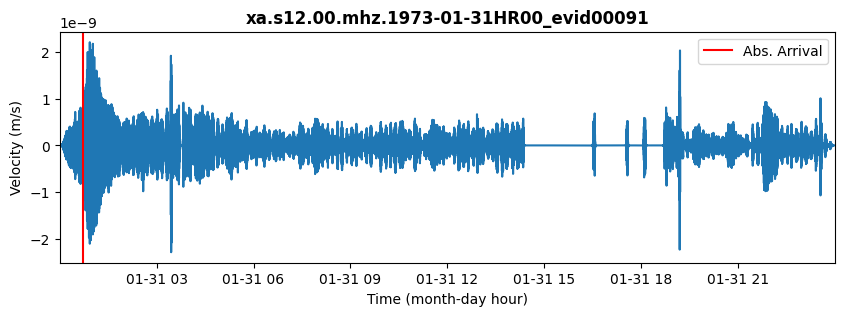

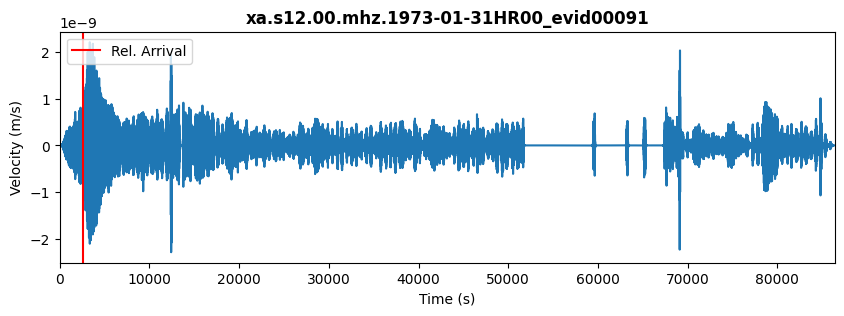

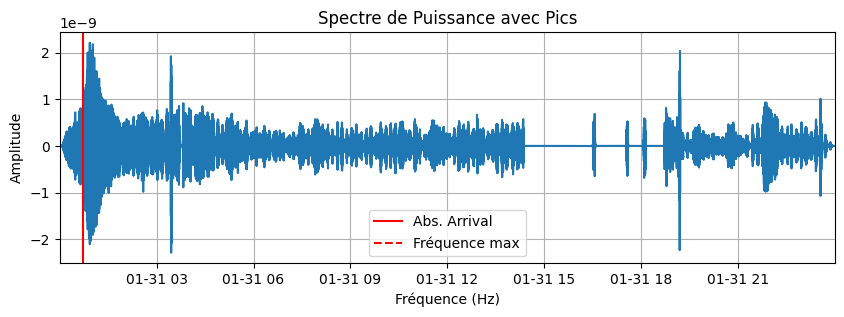

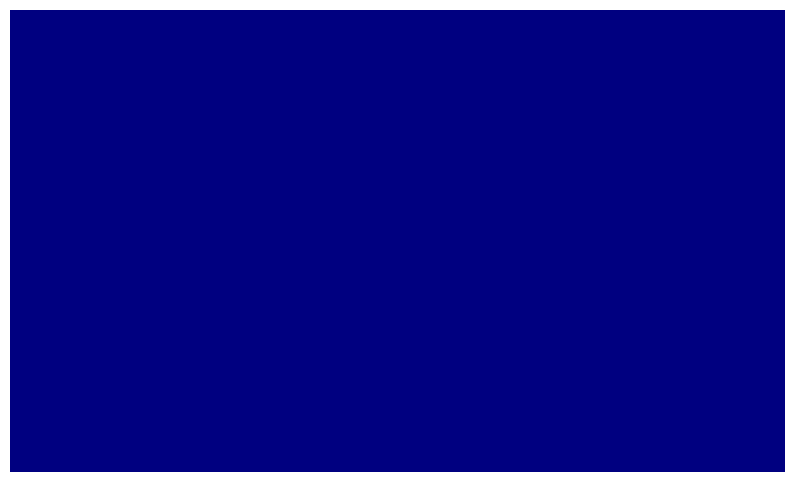

Largeur à mi-hauteur (FWHM) : 0.08105697503928411
Pourcentage basé sur la largeur à mi-hauteur : 9.78806925719093
Fréquence maximale : 0.8281201625104416 Hz
Amplitude maximale : 1.072133713068412e-10
0.7470631874711575 0.9091771375497257


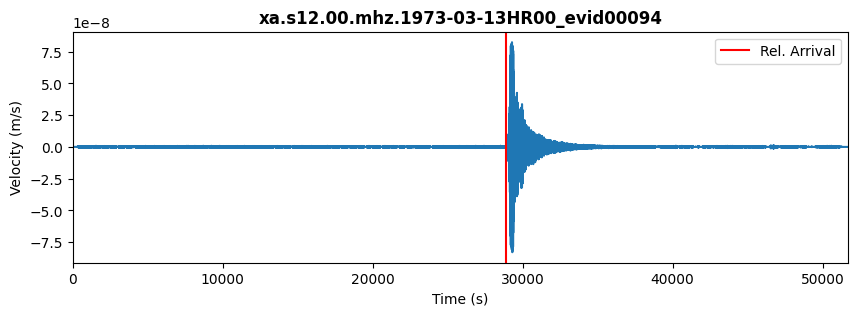

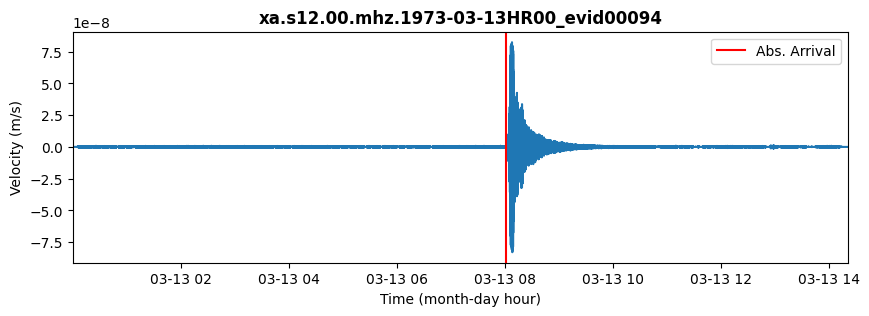

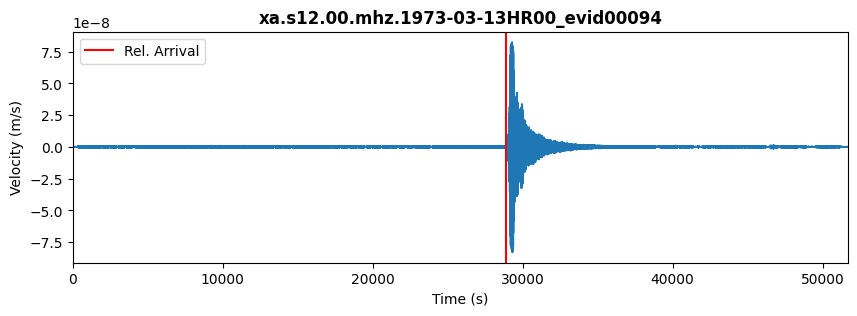

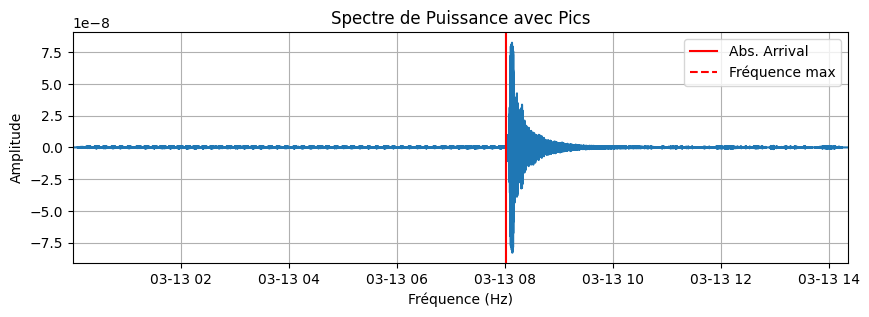

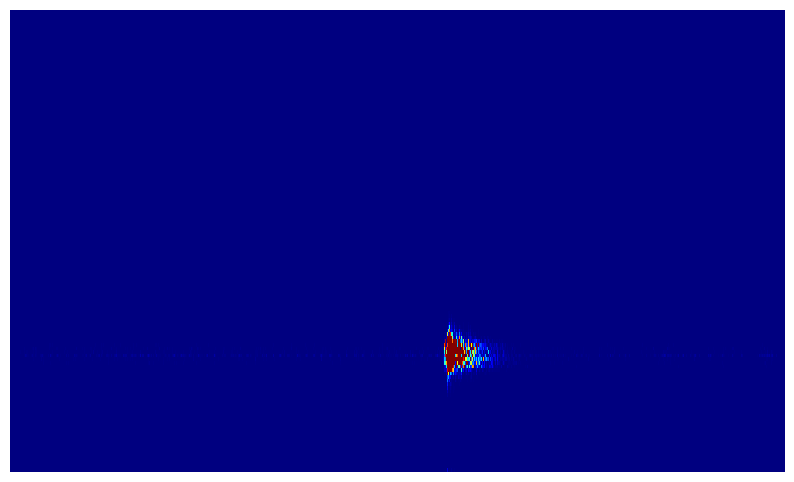

Largeur à mi-hauteur (FWHM) : 4.629508311271291e-05
Pourcentage basé sur la largeur à mi-hauteur : 0.005590261763999412
Fréquence maximale : 0.8281380204921255 Hz
Amplitude maximale : 2.663790722692094e-11
0.8280917254090128 0.8281843155752382


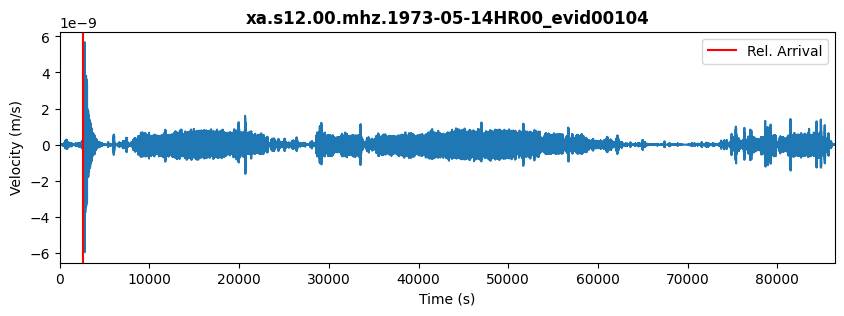

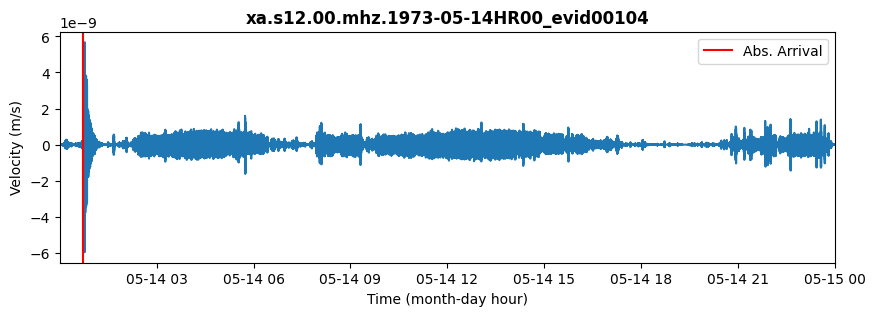

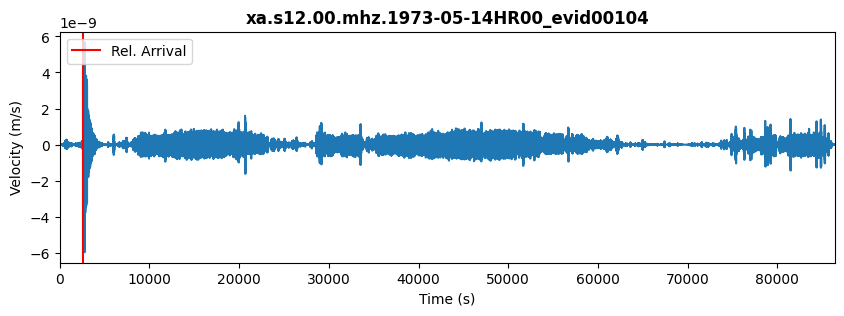

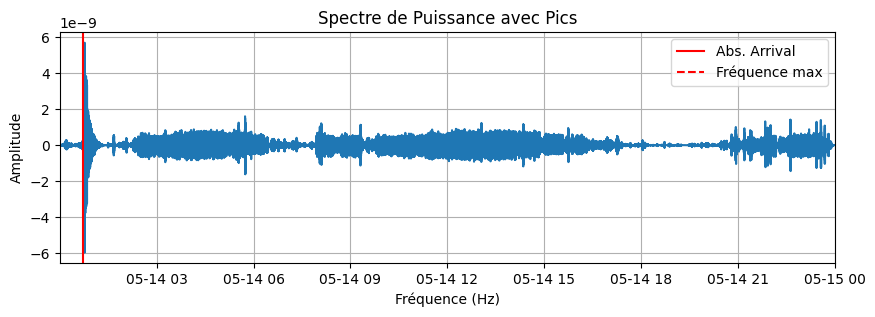

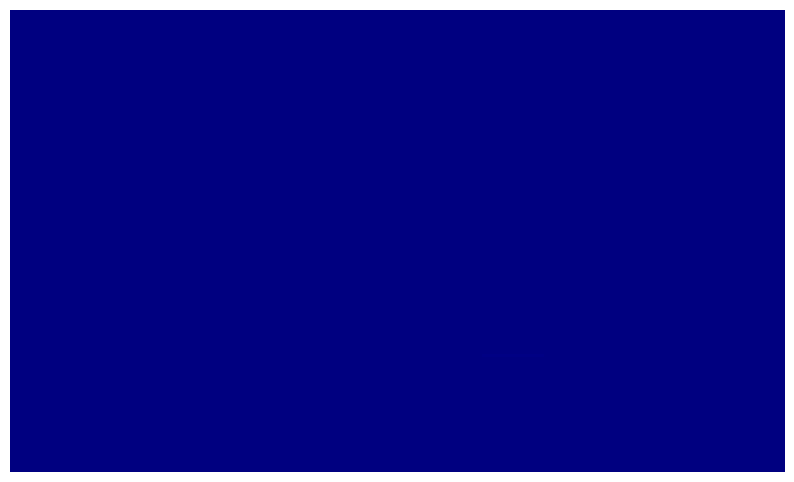

KeyboardInterrupt: 

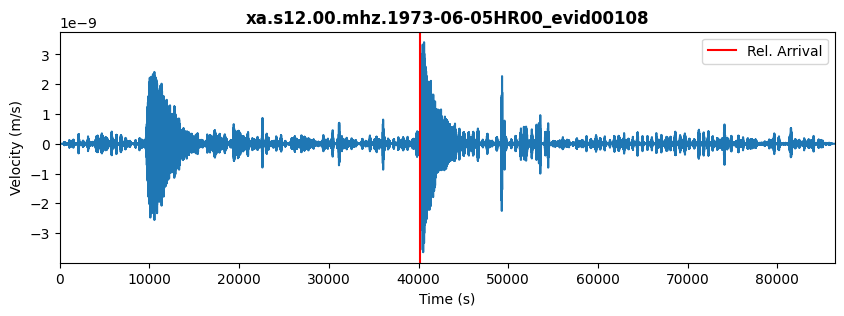

In [31]:
#Boucle sur les fichiers de test
image_paths = []  # Liste des chemins d'accès aux images
labels = [0] * 78  # Initialisation de la liste des labels (0 ou 1)

for i in range(78):
    if i % 2 != 0:  # Utilisation correcte de l'opérateur != pour les indices impairs
        result = spectrogramme(i)  # Appeler la fonction spectrogramme pour les indices impairs
        labels[i] = 1  # Étiqueter comme séisme
        image_paths.append(f'spectrogram_{i}.png')  # Ajouter le chemin d'accès à l'image à la liste
    else:
        # Charger l'image bleue
        image_bleue = cv2.imread('./imageBleue.png')

        # Définir le chemin de sauvegarde de la nouvelle image
        new_image_path = f'./spectrogram_{i}.png'

        # Enregistrer l'image bleue sous un nouveau nom
        cv2.imwrite(new_image_path, image_bleue)

        # Ajouter ce chemin à la liste image_paths (si nécessaire)
        image_paths.append(new_image_path)

        # Étiqueter comme non-séisme
        labels[i] = 0

# Optionnel : Vérifier les listes finales
print(f"Image paths: {image_paths}")
print(f"Labels: {labels}")
    

In [35]:
# labels1 = [0] * (len(image_paths) + 1)
# for i in range(0, len(image_paths) + 1) : 
#     labels1[i] = labels[i]
# print(labels, image_paths)
[0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0]
print(len(labels), len(image_paths))


77 77


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chargement des images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris
        img = cv2.resize(img, (224, 224))  # Redimensionner
        img = img / 255.0  # Normaliser
        images.append(img)
    return np.array(images)

labels = [0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0]
image_paths = [f'./spectrogram_{i}.png' for i in range(77)]
print(labels, image_paths)

# Prétraitement
X = load_images(image_paths)
y = np.array(labels)

# Ajouter une dimension pour les canaux
X = X.reshape(X.shape[0], 224, 224, 1)  # (nombre d'exemples, hauteur, largeur, 1)

# Division de l'ensemble de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un générateur d'images pour l'entraînement
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Retourner verticalement
    brightness_range=[0.8, 1.2],  # Ajustement de la luminosité
    fill_mode='nearest',  # Remplissage des pixels vides
)

# Modèle simple avec TensorFlow/Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour la classification binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement
model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=60)


# Évaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

model.save('my_model.h5')  # Save the model to a file named 'my_model.h5'
print("Model saved as 'my_model.h5'")



2024-10-06 12:05:30.385633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 12:05:30.395072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 12:05:30.405313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 12:05:30.422203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 12:05:30.426816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 12:05:30.441849: I tensorflow/core/platform/cpu_feature_gu

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] ['./spectrogram_0.png', './spectrogram_1.png', './spectrogram_2.png', './spectrogram_3.png', './spectrogram_4.png', './spectrogram_5.png', './spectrogram_6.png', './spectrogram_7.png', './spectrogram_8.png', './spectrogram_9.png', './spectrogram_10.png', './spectrogram_11.png', './spectrogram_12.png', './spectrogram_13.png', './spectrogram_14.png', './spectrogram_15.png', './spectrogram_16.png', './spectrogram_17.png', './spectrogram_18.png', './spectrogram_19.png', './spectrogram_20.png', './spectrogram_21.png', './spectrogram_22.png', './spectrogram_23.png', './spectrogram_24.png', './spectrogram_25.png', './spectrogram_26.png', './spectrogram_27.png', './spectrogram_28.png', './spectrogram_29.png', './spectrogram_30.png', './spectrogram_31.png', './spectr

/home/salim/Informatique/Nasa/space_apps_2024_seismic_detection/mon_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/salim/Informatique/Nasa/space_apps_2024_seismic_detection/mon_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5619 - loss: 0.6931

2024-10-06 12:05:36.810643: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37850112 exceeds 10% of free system memory.
2024-10-06 12:05:36.854846: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37850112 exceeds 10% of free system memory.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.5768 - loss: 0.6931 - val_accuracy: 0.8125 - val_loss: 0.6879
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6687 - loss: 0.6929 - val_accuracy: 0.8125 - val_loss: 0.6874
Epoch 3/60


2024-10-06 12:05:37.354591: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37850112 exceeds 10% of free system memory.
2024-10-06 12:05:37.389876: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37850112 exceeds 10% of free system memory.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6250 - loss: 0.6927

2024-10-06 12:05:37.589363: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37850112 exceeds 10% of free system memory.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6127 - loss: 0.6928 - val_accuracy: 0.8125 - val_loss: 0.6870
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6113 - loss: 0.6926 - val_accuracy: 0.8125 - val_loss: 0.6866
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5883 - loss: 0.6926 - val_accuracy: 0.8125 - val_loss: 0.6862
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6127 - loss: 0.6923 - val_accuracy: 0.8125 - val_loss: 0.6857
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6127 - loss: 0.6921 - val_accuracy: 0.8125 - val_loss: 0.6852
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5653 - loss: 0.6924 - val_accuracy: 0.8125 - val_loss: 0.6847
Epoch 9/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6335 - loss: 0.6915 - val_accuracy: 0.8125 - val_loss: 0.6843
Epoch 10/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6127 - loss: 0.6916 - val_accuracy: 0.8125 - val_loss: 0.6838
Ep

Accuracy: 81.25%
Model saved as 'my_model.h5'


In [22]:
import cv2
import numpy as np

# Autre approche itérative sans machine learning
# On parcourt tous les pixels de l'image et si au moins 3 pixels ne sont pas identiques au pixel de référence, alors il y a un séisme

def detect_seisme(image_path, tolerance=1):
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Si l'image n'est pas chargée correctement
    if img is None:
        print(f"Erreur : Impossible de charger l'image {image_path}")
        return False
    
    # Obtenir les dimensions de l'image
    height, width = img.shape
    
    # Obtenir la valeur du pixel en haut à gauche (ou une autre référence)
    top_left_pixel = img[0, 0]

    # Liste pour stocker les positions des pixels "colorés" (différents du fond)
    colored_pixels_x = []
    
    # Compteur pour les pixels qui diffèrent
    diff_pixel_count = 0
    
    # Boucler sur chaque pixel de l'image
    for i in range(height):
        for j in range(width):
            # Comparer chaque pixel avec le pixel en haut à gauche
            if img[i, j] != top_left_pixel:
                diff_pixel_count += 1
                colored_pixels_x.append(j)
                
                # Si plus de trois pixels sont différents, on détecte un séisme
                if diff_pixel_count > tolerance:
                    print(f"Seisme détecté pour l'image {image_path}")
                    return True
                
    
    # Si moins de trois pixels sont différents, pas de séisme
    print(f"Pas de séisme détecté pour l'image {image_path}")
    return False


# Initialisation des labels
Labels1 = [0] * 77
labels = [0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0]

# Parcourir chaque spectrogramme
for i in range(77):
    image_path = f'./spectrogram_{i}.png'  # Correction du chemin de l'image
    if detect_seisme(image_path, tolerance=3):
        Labels1[i] = 1  # Séisme détecté
    else:
        Labels1[i] = 0  # Pas de séisme

# Comparer les labels générés avec les labels existants
if np.array_equal(Labels1, labels):
    print("L'approche est totalement validée à 100%")
else:
    print("L'approche n'est pas validée à 100%, vérifiez les résultats.")
print(Labels1)
print(labels)

# Calcul de la précision
correct = 0
for i in range(77):
    if Labels1[i] == labels[i]:
        correct += 1
accuracy = correct / 77
print(f"Précision : {accuracy * 100:.2f}%")




Pas de séisme détecté pour l'image ./spectrogram_0.png
Seisme détecté pour l'image ./spectrogram_1.png
Pas de séisme détecté pour l'image ./spectrogram_2.png
Seisme détecté pour l'image ./spectrogram_3.png
Pas de séisme détecté pour l'image ./spectrogram_4.png
Seisme détecté pour l'image ./spectrogram_5.png
Pas de séisme détecté pour l'image ./spectrogram_6.png
Seisme détecté pour l'image ./spectrogram_7.png
Pas de séisme détecté pour l'image ./spectrogram_8.png
Seisme détecté pour l'image ./spectrogram_9.png
Pas de séisme détecté pour l'image ./spectrogram_10.png
Pas de séisme détecté pour l'image ./spectrogram_11.png
Pas de séisme détecté pour l'image ./spectrogram_12.png
Seisme détecté pour l'image ./spectrogram_13.png
Pas de séisme détecté pour l'image ./spectrogram_14.png
Seisme détecté pour l'image ./spectrogram_15.png
Pas de séisme détecté pour l'image ./spectrogram_16.png
Seisme détecté pour l'image ./spectrogram_17.png
Pas de séisme détecté pour l'image ./spectrogram_18.png
Pa

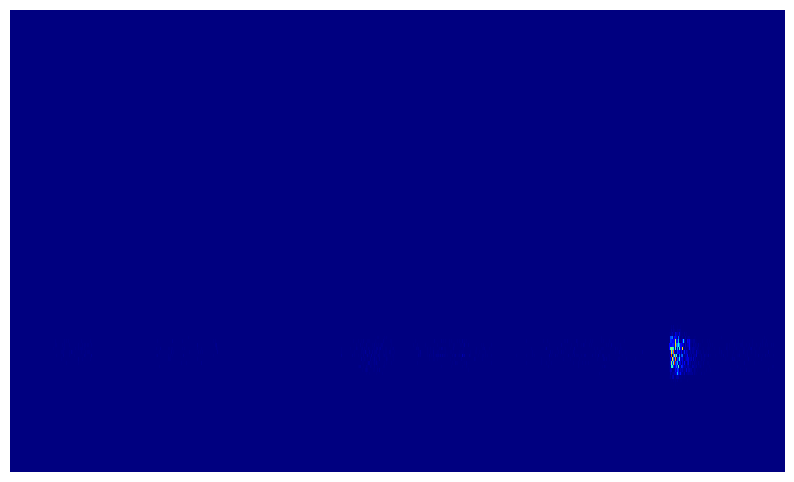

Position de début du séisme (pixel) : 130, Temps associé : 4414.792452830188
Position de fin du séisme (pixel) : 2291, Temps associé : 77481.05660377358
durée du séisme : 1217.77106918239 minutes


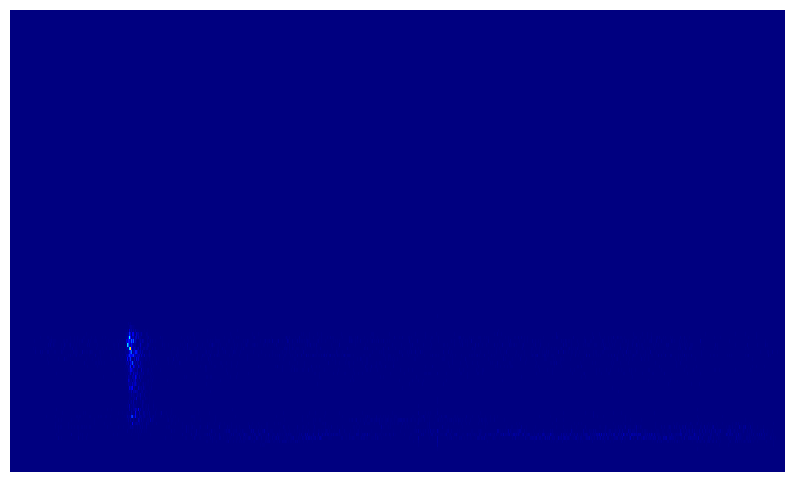

Position de début du séisme (pixel) : 50, Temps associé : 1709.8867924528302
Position de fin du séisme (pixel) : 2302, Temps associé : 77852.98113207547
durée du séisme : 1269.051572327044 minutes


ValueError: Wn[0] must be less than Wn[1]

In [34]:
import cv2
import numpy as np

# Autre approche itérative sans machine learning
# On parcourt tous les pixels de l'image et si au moins 3 pixels ne sont pas identiques au pixel de référence, alors il y a un séisme

def spectrogramme1(i):
    cat_directory = '../data/lunar/training/catalogs/'
    cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
    cat = pd.read_csv(cat_file)
    row = cat.iloc[i]
    
    # Extraire les temps d'arrivée
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    arrival_time_rel = row['time_rel(sec)']
    test_filename = row.filename
    data_directory = '../data/lunar/training/data/S12_GradeA/'
    
    # Lire le fichier mseed
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)

    # Extraire les données du premier trace
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    
    # Calculer la FFT du signal
    n = len(tr.data)
    sampling_rate = tr.stats.sampling_rate
    T = 1.0 / sampling_rate
    yf = fft(tr.data)
    xf = np.fft.fftfreq(n, T)[:n // 2]
    spectrum = 2.0 / n * np.abs(yf[0:n // 2])
    
    # Trouver la fréquence et l'amplitude maximales
    max_index = np.argmax(spectrum)
    max_frequency = xf[max_index]
    max_amplitude = spectrum[max_index]

    # Calculer la largeur à mi-hauteur (FWHM)
    half_max = max_amplitude / 2
    indices_above_half_max = np.where(spectrum >= half_max)[0]
    
    if len(indices_above_half_max) > 0:
        fwhm = xf[indices_above_half_max[-1]] - xf[indices_above_half_max[0]]
    else:
        fwhm = 0

    # Calculer la bande passante du filtre
    span = (fwhm / max_frequency) * max_frequency
    minfreq = max_frequency - span if span <= max_frequency else 0.0001
    maxfreq = max_frequency + span
    
    # Filtrage du signal
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    # Calculer le spectrogramme
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

    # Sauvegarder le spectrogramme
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(1, 1, 1)
    ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax.set_axis_off()
    plt.savefig(f'spectrogram_{i}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    
    # Afficher le spectrogramme
    plt.show()
    
    return t  # Retourner les valeurs de temps du spectrogramme

def detect_start_end(image_path, tolerance=1):
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Si l'image n'est pas chargée correctement
    if img is None:
        print(f"Erreur : Impossible de charger l'image {image_path}")
        return False
    
    # Obtenir les dimensions de l'image
    height, width = img.shape
    
    # Obtenir la valeur du pixel en haut à gauche (ou une autre référence)
    top_left_pixel = img[0, 0]

    # Liste pour stocker les positions des pixels "colorés" (différents du fond)
    colored_pixels_x = []
    
    # Compteur pour les pixels qui diffèrent
    diff_pixel_count = 0
    
    # Boucler sur chaque pixel de l'image
    for i in range(height):
        for j in range(width):
            # Comparer chaque pixel avec le pixel en haut à gauche
            if img[i, j] != top_left_pixel:
                diff_pixel_count += 1
                colored_pixels_x.append(j)           
    
    if colored_pixels_x:
        seismic_start = min(colored_pixels_x)  # Position du premier pixel coloré
        seismic_end = max(colored_pixels_x)    # Position du dernier pixel coloré
        return seismic_start, seismic_end
    else:
        return None, None  # Aucun séisme détecté (aucun pixel coloré)
    



# Executons l'algorithme sur toutes les données
for i in range(3):
    image_path = f'./spectrogram_{i}.png'  # Correction du chemin de l'image
    
    # Générer le spectrogramme et récupérer les abscisses temporelles
    t = spectrogramme1(i)
    
    # Détecter les pixels "différents"
    start, end = detect_start_end(image_path, tolerance=3)
    
    if start is not None and end is not None:
        # Récupérer les abscisses en temps associées aux indices des pixels
        time_at_start = t[start] if start < len(t) else None
        time_at_end = t[end] if end < len(t) else None
        
        print(f"Position de début du séisme (pixel) : {start}, Temps associé : {time_at_start}")
        print(f"Position de fin du séisme (pixel) : {end}, Temps associé : {time_at_end}")
    else:
        print("Aucun séisme détecté.")